In [1]:
!pip install plantcv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 286 kB 4.7 MB/s 
     |████████████████████████████████| 41 kB 444 kB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from plantcv import plantcv as pcv
from google.colab.patches import cv2_imshow
from skimage.morphology import medial_axis, skeletonize
from skimage.filters import threshold_otsu,gaussian
from skimage.io import imread
from skimage.color import rgb2gray
import tensorflow as tf
import keras

In [3]:
def connectedcomp(img , blurring=5):
# preprocess the image
    gray_img = cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)
 
    # Applying 3x3 Gaussian Blur
    blurred = cv2.GaussianBlur(gray_img, (blurring,blurring), 0)
 
    # Applying threshold
    threshold = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #print(threshold)
    # Apply the Component analysis function
    analysis = cv2.connectedComponentsWithStats(threshold,4,cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
 
    # Initialize a new image to
    # store all the output components
    output = np.zeros(gray_img.shape, dtype="uint8")
 
    # Loop through each component
    for i in range(1, totalLabels):
    
      # Area of the component
        area = values[i, cv2.CC_STAT_AREA]
            #print(area) 
        if (area > 50):
            # Create a new image for bounding boxes
            new_img=img.copy()
            
            # Now extract the coordinate points
            x1 = values[i, cv2.CC_STAT_LEFT]
            y1 = values[i, cv2.CC_STAT_TOP]
            w = values[i, cv2.CC_STAT_WIDTH]
            h = values[i, cv2.CC_STAT_HEIGHT]
            
            # Coordinate of the bounding box
            pt1 = (x1, y1)
            pt2 = (x1+ w, y1+ h)
            (X, Y) = centroid[i]
            
            # Bounding boxes for each component
            cv2.rectangle(new_img,pt1,pt2,
                          (0, 255, 0), 3)
            cv2.circle(new_img, (int(X),
                                int(Y)),
                      4, (0, 0, 255), -1)
    
            # Create a new array to show individual component
            component = np.zeros(gray_img.shape, dtype="uint8")
            componentMask = (label_ids == i).astype("uint8") * 255
    
            # Apply the mask using the bitwise operator
            component = cv2.bitwise_or(component,componentMask)
            output = cv2.bitwise_or(output, componentMask)
            
            # Show the final images
            #cv2_imshow(new_img)
            #cv2_imshow(component)
    
    cv2_imshow(output)
    return output
    #cv2.imwrite('/content/drive/MyDrive/LineSegmentation/1.jpg',output)
        #print(area)
        #print('------------------------------------------')

In [4]:
def lineseg(img):
    print('Line seg')
    print('----------------------------------------------------')
    res=[]
    #T, image = cv2.threshold(gray, 100, 255,
      #cv2.THRESH_BINARY_INV)
    #cv2_imshow(threshInv)
    #image = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    #cv2_imshow(image)
    #Line Segmentation
    '''if len(img.shape)==3:
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)'''
    gray=img
    ret, thresh2 = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,2))
    #Have to change Kernel Value to obtain correct mask for different images
    mask = cv2.morphologyEx(thresh2, cv2.MORPH_DILATE, kernel)
    #cv2_imshow(thresh2)
    cv2_imshow(mask)
    print('After mask')
    bboxes = []
    bboxes_img = gray.copy()
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(bboxes_img, (x, y), (x+w, y+h), (0,0,255), 1)
        bboxes.append((x,y,w,h))
    for j in range(len(bboxes)):
        (x,y,w,h) = bboxes[j]
        crop = gray[y:y+h, x:x+w]
        cv2_imshow(crop)
        #print(crop.shape)
        #cv2.imwrite('/content/drive/MyDrive/LineSegmentation/brahmi10/{}.jpg'.format(j),crop)
        res.append(crop)
        print('Lines')
    return res

In [5]:
def charseg(crop,char_seg_height=10):
    #Character Segmentation
    #crop=cv2.imread(r'/content/drive/MyDrive/LineSegmentation/b1/b10.jpg')
    #crop=cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)


    #plt.imshow(crop, cmap="gray")
    #plt.show()


    #binarize the image, guassian blur will remove any noise in the image
    '''thresh = threshold_otsu(gaussian(crop))
    binary = crop > thresh'''
    print('char seg')
    print('----------------------------------------------------')
    res=[]
    # find the vertical projection by adding up the values of all pixels along rows
    vertical_projection = np.sum(crop, axis=0)
    vertical_projection=vertical_projection/255
    vertical_projection = [round(item) for item in vertical_projection]
    # plot the vertical projects
    fig, ax = plt.subplots(nrows=2)
    plt.xlim(0, crop.shape[1])
    ax[0].imshow(crop, cmap="gray")
    ax[1].plot(vertical_projection)
    #Continuation of Word Segmentation, works well if there is more than 1 word
    height = crop.shape[0]
    width=crop.shape[1]
    #print(width)
    #print(height)
    height-=height/char_seg_height
    ## we will go through the vertical projections and 
    ## find the sequence of consecutive white spaces in the image
    whitespace_lengths = []
    whitespace = 0
    #print(vertical_projection)
    for vp in vertical_projection:
        if vp >= height:
            whitespace = whitespace + 1
        elif vp < height:
            if whitespace != 0:
                whitespace_lengths.append(whitespace)
            whitespace = 0 # reset whitepsace counter. 
    if whitespace!=0:
      whitespace_lengths.append(whitespace)
    #print("whitespaces:", whitespace_lengths)
    #avg_white_space_length = min(whitespace_lengths)
    avg_white_space_length=min(whitespace_lengths)
    #print("average whitespace lenght:", avg_white_space_length)
    whitespace_length = 0
    divider_indexes = []
    divider_indexes.append(0)
    for index, vp in enumerate(vertical_projection):
        if vp >= height:
            whitespace_length = whitespace_length + 1
        elif vp < height:
            if whitespace_length != 0 and whitespace_length >= avg_white_space_length:
                #print(whitespace_length)
                divider_indexes.append(index-int(whitespace_length/2))
            whitespace_length = 0 # reset it
    divider_indexes.append(index-int(whitespace_length/2))            
    #print(divider_indexes)
    divider_indexes = np.array(divider_indexes)
    dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))
    #print(dividers)
    fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
    if len(dividers)==1:
      pass
      #ax.imshow(crop[:,dividers[0][0]:dividers[0][1]], cmap="gray")
    else:
        for index, window in enumerate(dividers):
          #ax[index].axis("off")
          #cv2.imwrite('/content/drive/MyDrive/LineSegmentation/b1/3/{}.jpg'.format(index),crop[:,window[0]:window[1]])
          res.append(crop[:,window[0]:window[1]])
          ax[index].imshow(crop[:,window[0]:window[1]], cmap="gray")
    return res

In [6]:
#Skeletonization

def skeletonize1(charImg):
    print('Skeletonization')
    print('----------------------------------------------------')
    img_inverse=255-charImg
    size = np.size(img_inverse)
    skel = np.zeros(img_inverse.shape,np.uint8)

    ret,img_inverse = cv2.threshold(img_inverse,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        #print(element.shape)
        #print(img_inverse.shape)
        eroded = cv2.erode(img_inverse,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img_inverse,temp)
        skel = cv2.bitwise_or(skel,temp)
        img_inverse = eroded.copy()

        zeros = size - cv2.countNonZero(img_inverse)
        if zeros==size:
            done = True
    cv2_imshow(skel)
    return skel

def skeletonize2(charImg):
  #big_img = cv2.resize(charImg, (2 * charImg.shape[1], 2 * charImg.shape[0]))
  #cv2_imshow(img_inverse)
  ret,charImg = cv2.threshold(charImg,127,255,0)
  curImg = skeletonize(charImg)
  return curImg
  
def skeletonize3(charImg):
  img_inverse=255-charImg
  skel, distance = medial_axis(img_inverse, return_distance=True)
  return skel


def prune(skeleton):
  skeleton_big = cv2.resize(skeleton, (2 * skeleton.shape[1], 2 * skeleton.shape[0]))
  #pcv.params.debug = "plot"

  element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  dil = cv2.dilate(skeleton_big,element)

  pruned_skeleton, segmented_img, segment_objects = pcv.morphology.prune(skel_img=dil, size=70)
  
  kernel = np.ones((3, 3), np.uint8)
  img_dilation = cv2.dilate(pruned_skeleton, kernel, iterations=2)

  ret,binImg = cv2.threshold(img_dilation,127,255,cv2.THRESH_BINARY)

  res = 255 - binImg
  cv2_imshow(res)
  return res

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
model = keras.models.load_model('/content/drive/MyDrive/Capstone Project/ocrmodels/model_60')

In [9]:
def predict_chars(images):
  num_to_name = {0: 'a', 1: 'a(3)', 2: 'a(4)', 3: 'a(5)', 4: 'aaa', 5: 'ba', 6: 'ba(2)', 7: 'baa', 8: 'be', 9: 'bha', 10: 'bhaa', 11: 'bhe', 12: 'bhi', 13: 'bhii', 14: 'bho', 15: 'bhu', 16: 'bhuu', 17: 'bi', 18: 'bii', 19: 'bo', 20: 'bo(2)', 21: 'bu', 22: 'buu', 23: 'ca', 24: 'caa', 25: 'ce', 26: 'cha', 27: 'chaa', 28: 'che', 29: 'chi', 30: 'chii', 31: 'cho', 32: 'chu', 33: 'chuu', 34: 'ci', 35: 'cii', 36: 'co', 37: 'cu', 38: 'cuu', 39: 'da(2)', 40: 'daa', 41: 'daa(2)', 42: 'daaa', 43: 'daaaa', 44: 'dae', 45: 'dai', 46: 'daii', 47: 'dao', 48: 'dau', 49: 'dauu', 50: 'de', 51: 'dha', 52: 'dhaa', 53: 'dhaaa', 54: 'dhaaaa', 55: 'dhae', 56: 'dhai', 57: 'dhaii', 58: 'dhao', 59: 'dhau', 60: 'dhauu', 61: 'dhi', 62: 'dhii', 63: 'dho', 64: 'dhu', 65: 'dhue', 66: 'dhuu', 67: 'di', 68: 'dii', 69: 'do', 70: 'du', 71: 'duu', 72: 'e', 73: 'ee', 74: 'ga', 75: 'gaa', 76: 'ge', 77: 'gha', 78: 'ghaa', 79: 'ghe', 80: 'ghi', 81: 'ghii', 82: 'gho', 83: 'ghu', 84: 'ghuu', 85: 'gi', 86: 'gii', 87: 'go', 88: 'gu', 89: 'guu', 90: 'ha', 91: 'haa', 92: 'he', 93: 'hi', 94: 'hii', 95: 'ho', 96: 'hu', 97: 'huu', 98: 'i', 99: 'ja', 100: 'ja(2)', 101: 'ja(3)', 102: 'ja(4)', 103: 'jaa', 104: 'je', 105: 'jha', 106: 'jhaa', 107: 'jhe', 108: 'jhi', 109: 'jhii', 110: 'jho', 111: 'jhu', 112: 'jhuu', 113: 'ji', 114: 'jii', 115: 'jo', 116: 'ju', 117: 'juu', 118: 'ka', 119: 'kaa', 120: 'ke', 121: 'kha', 122: 'kha(2)', 123: 'khaa', 124: 'khaa(2)', 125: 'khe', 126: 'khe(2)', 127: 'khi', 128: 'khii', 129: 'khii(2)', 130: 'kho', 131: 'kho(2)', 132: 'khu', 133: 'khu(2)', 134: 'khuu', 135: 'khuu(2)', 136: 'ki', 137: 'kii', 138: 'ko', 139: 'ku', 140: 'kuu', 141: 'la', 142: 'la(2)', 143: 'la(3)', 144: 'laa', 145: 'le', 146: 'li', 147: 'lii', 148: 'lo', 149: 'lu', 150: 'luu', 151: 'ma', 152: 'ma(2)', 153: 'maa', 154: 'me', 155: 'mi', 156: 'mii', 157: 'mo', 158: 'mu', 159: 'muu', 160: 'na', 161: 'na(2)', 162: 'naa', 163: 'ne', 164: 'ni', 165: 'nii', 166: 'nna', 167: 'nnaa', 168: 'nne', 169: 'nni', 170: 'nnii', 171: 'nno', 172: 'nno(2)', 173: 'nnu', 174: 'nnuu', 175: 'no', 176: 'nu', 177: 'nuu', 178: 'nya', 179: 'nya(2)', 180: 'o', 181: 'o(2)', 182: 'pa', 183: 'paa', 184: 'pe', 185: 'pha', 186: 'pha(2)', 187: 'phaa', 188: 'phe', 189: 'phi', 190: 'phii', 191: 'pho', 192: 'phu', 193: 'phuu', 194: 'pi', 195: 'pii', 196: 'po', 197: 'pu', 198: 'puu', 199: 'ra', 200: 'ra(2)', 201: 'ra(3)', 202: 'raa', 203: 're', 204: 'ri', 205: 'rii', 206: 'ro', 207: 'ru', 208: 'ruu', 209: 'sa', 210: 'sa(2)', 211: 'saa', 212: 'se', 213: 'sha', 214: 'shaa', 215: 'shaaa', 216: 'shaaaa', 217: 'shae', 218: 'shai', 219: 'shaii', 220: 'shao', 221: 'shau', 222: 'she', 223: 'shi', 224: 'shii', 225: 'sho', 226: 'shu', 227: 'shuu', 228: 'si', 229: 'sii', 230: 'so', 231: 'su', 232: 'suu', 233: 'ta', 234: 'taa', 235: 'taaa', 236: 'taaaa', 237: 'tae', 238: 'tai', 239: 'taii', 240: 'tao', 241: 'tau', 242: 'tauu', 243: 'te', 244: 'tha', 245: 'tha(2)', 246: 'thaa', 247: 'thaaa', 248: 'thaaaa', 249: 'thaai', 250: 'thae', 251: 'thai', 252: 'thaii', 253: 'thao', 254: 'thau', 255: 'thauu', 256: 'the', 257: 'the(2)', 258: 'thi', 259: 'thii', 260: 'tho', 261: 'thu', 262: 'thuu', 263: 'tii', 264: 'to', 265: 'tu', 266: 'tuu', 267: 'va', 268: 'vaa', 269: 'vhu', 270: 'vhuu', 271: 'vi', 272: 'vii', 273: 'vu', 274: 'vu(2)', 275: 'vuu', 276: 'vuu(2)', 277: 'ya', 278: 'ya(2)', 279: 'yaa', 280: 'ye', 281: 'yi', 282: 'yii', 283: 'yo', 284: 'yo(2)', 285: 'yu', 286: 'yuu'}
  test_images = []
  for image_name in images:
        img_name = cv2.cvtColor(image_name ,cv2.COLOR_GRAY2BGR)
        curImg = cv2.resize(img_name, (75,75))
        test_images.append(curImg)
  test_images = np.array(test_images)
  test_images = tf.keras.applications.inception_resnet_v2.preprocess_input(test_images, data_format=None)      
  print(test_images.shape)
  predictions = model.predict(test_images)
  predictions = np.array(predictions)
  test_preds = []
  for pred in predictions:
          max_val = -1
          index_val = -1
          for idx, val in enumerate(pred):
                  if val > max_val:
                          max_val = val
                          index_val = idx
          test_preds.append(num_to_name[index_val])
  return test_preds


In [10]:
def check_invert(img):
  white_count,black_count=0,0
  img_arr = np.array(img)
  for i in img_arr:
    for j in i:
      if j==255:
        white_count+=1
      elif j==0:
        black_count+=1
  if black_count>white_count:
    return 255-img
  return img
    

In [11]:
def line_thinning(img):
  kernel = np.ones((1, 1), np.uint8)
  img_erosion = cv2.dilate(img, kernel, iterations=2)
  #print('thinning')
  #cv2_imshow(img_erosion)
  return img_erosion

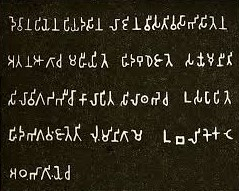

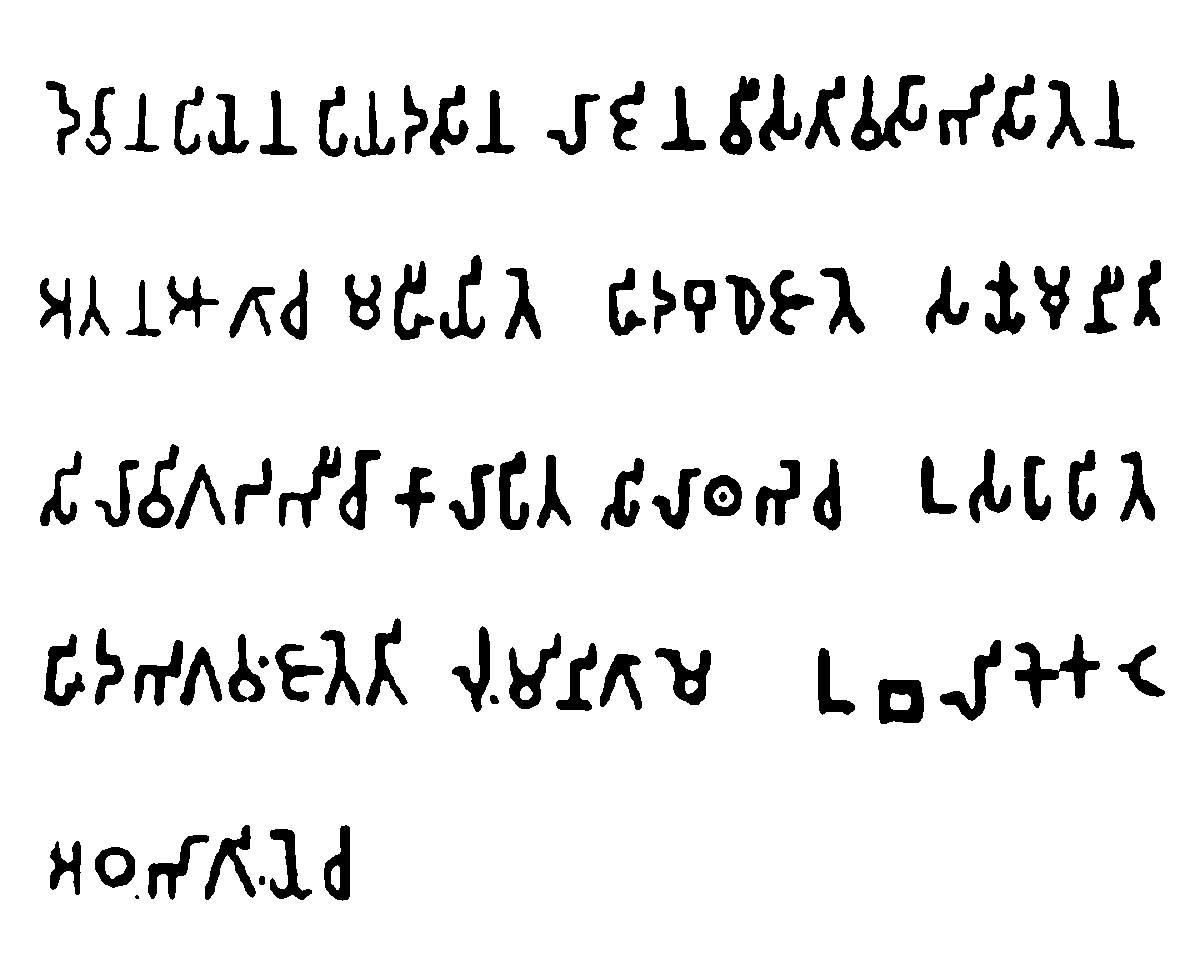

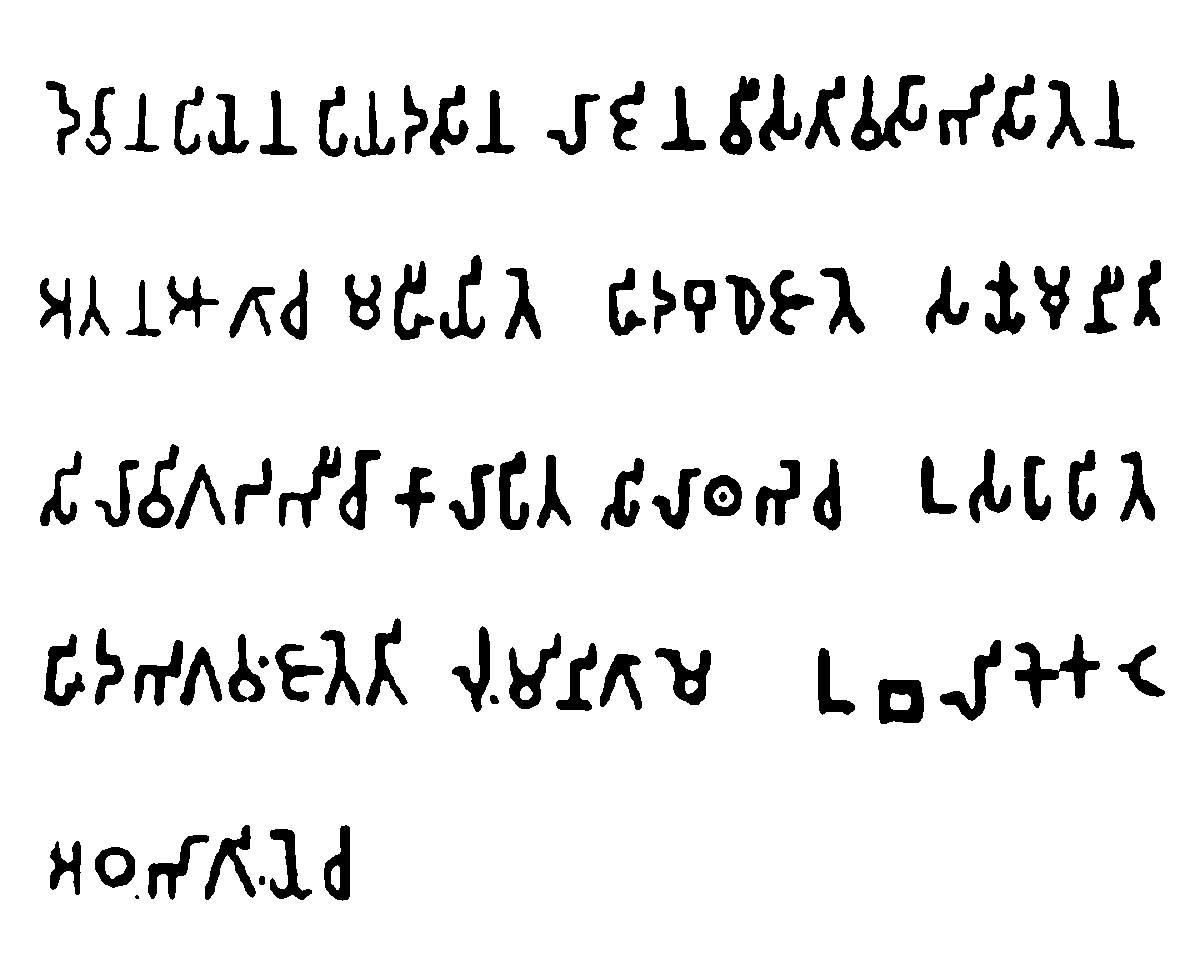

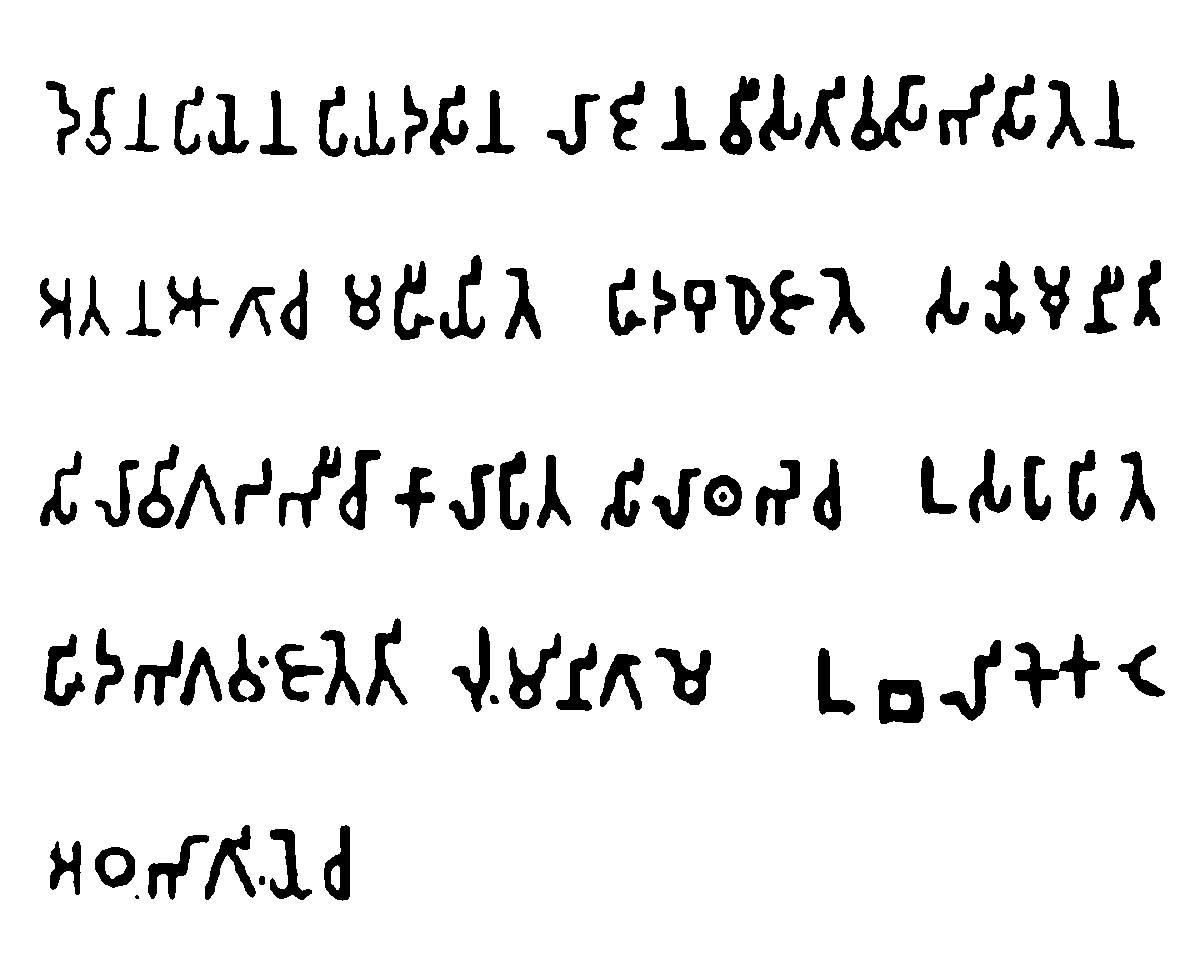

Line seg
----------------------------------------------------


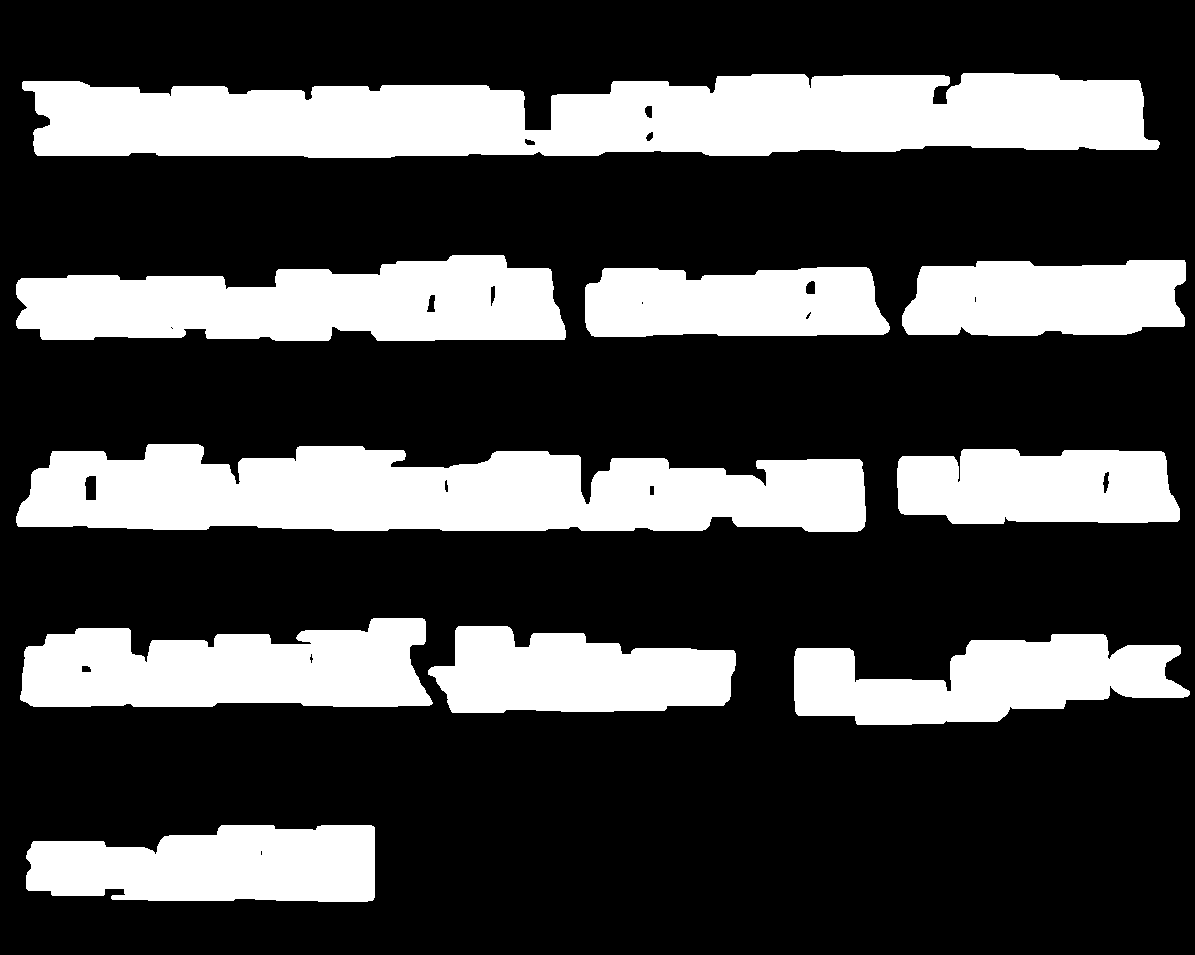

After mask


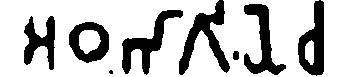

Lines


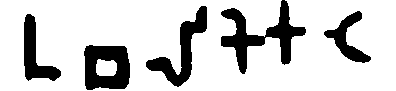

Lines


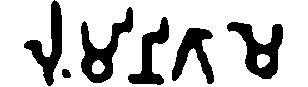

Lines


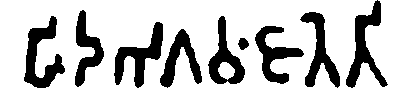

Lines


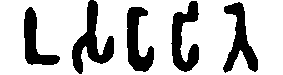

Lines


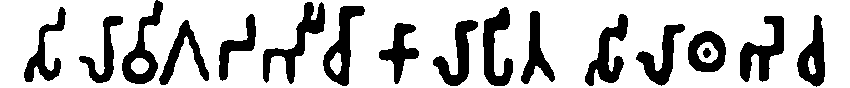

Lines


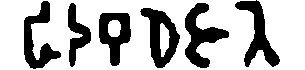

Lines


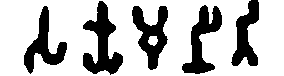

Lines


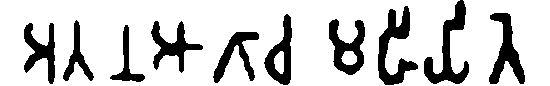

Lines


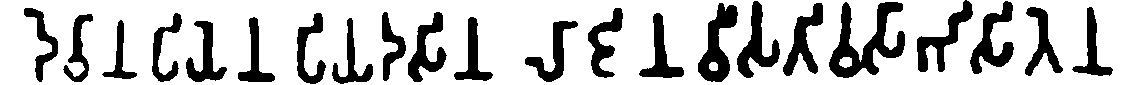

Lines
10
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


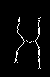

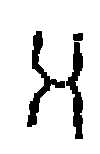

Skeletonization
----------------------------------------------------


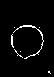

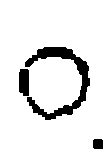

Skeletonization
----------------------------------------------------


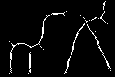

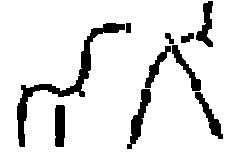

Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


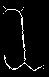

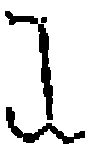

Skeletonization
----------------------------------------------------


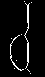

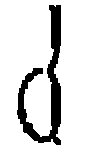

(7, 75, 75, 3)
1/1 [==============================] - 6s 6s/step
---------------


ee
---------------


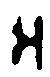

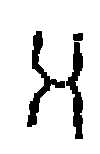

go
---------------


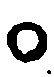

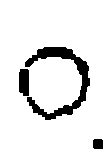

a(5)
---------------


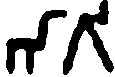

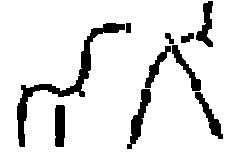

gi
---------------


ee
---------------


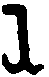

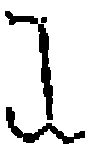

yo(2)
---------------


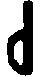

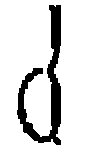

sa(2)
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


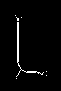

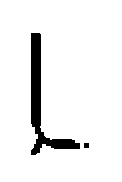

Skeletonization
----------------------------------------------------


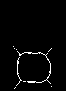

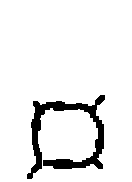

Skeletonization
----------------------------------------------------


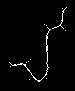

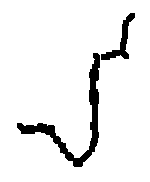

Skeletonization
----------------------------------------------------


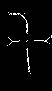

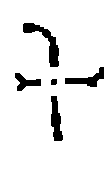

Skeletonization
----------------------------------------------------


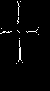

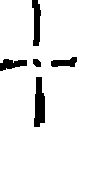

Skeletonization
----------------------------------------------------


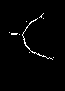

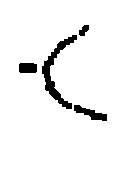

(7, 75, 75, 3)
1/1 [==============================] - 0s 230ms/step
---------------


ee
---------------


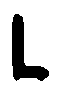

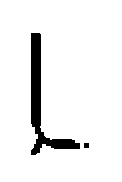

vhu
---------------


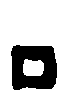

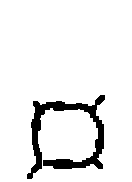

pha(2)
---------------


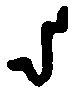

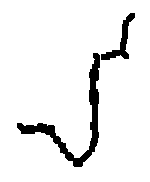

laa
---------------


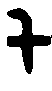

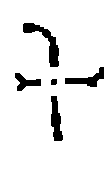

a(5)
---------------


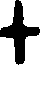

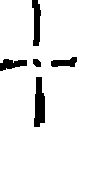

she
---------------


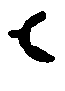

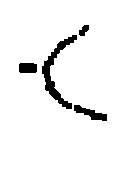

ja
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


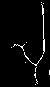

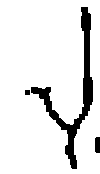

Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


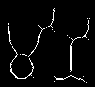

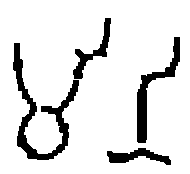

Skeletonization
----------------------------------------------------


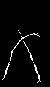

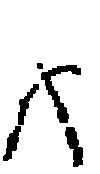

Skeletonization
----------------------------------------------------


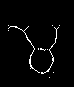

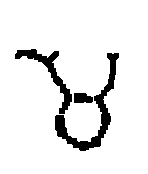

(6, 75, 75, 3)
1/1 [==============================] - 0s 210ms/step
---------------


ee
---------------


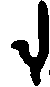

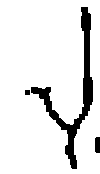

a(5)
---------------


na(2)
---------------


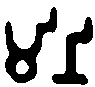

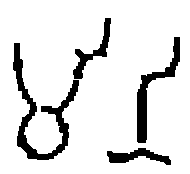

si
---------------


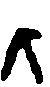

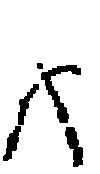

aaa
---------------


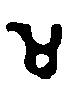

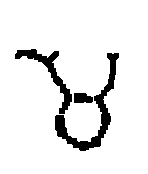

me
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


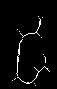

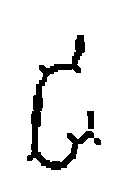

Skeletonization
----------------------------------------------------


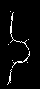

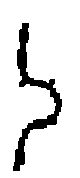

Skeletonization
----------------------------------------------------


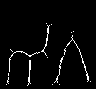

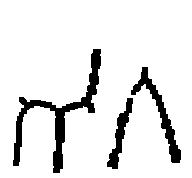

Skeletonization
----------------------------------------------------


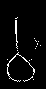

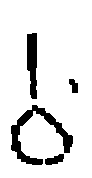

Skeletonization
----------------------------------------------------


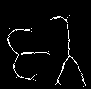

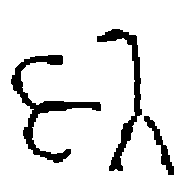

Skeletonization
----------------------------------------------------


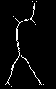

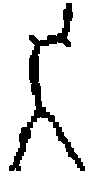

(7, 75, 75, 3)
1/1 [==============================] - 0s 216ms/step
---------------


ee
---------------


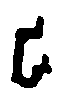

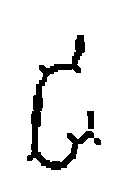

si
---------------


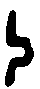

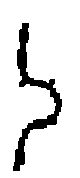

dha
---------------


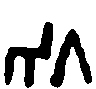

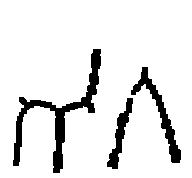

suu
---------------


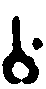

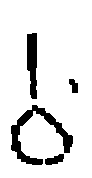

su
---------------


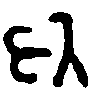

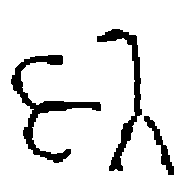

thaa
---------------


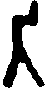

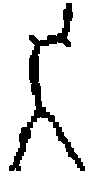

thi
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


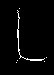

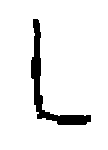

Skeletonization
----------------------------------------------------


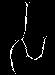

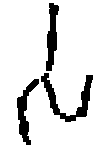

Skeletonization
----------------------------------------------------


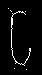

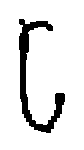

Skeletonization
----------------------------------------------------


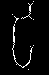

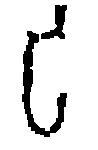

Skeletonization
----------------------------------------------------


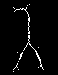

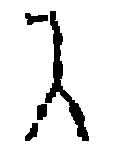

(6, 75, 75, 3)
1/1 [==============================] - 0s 230ms/step
---------------


ee
---------------


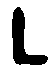

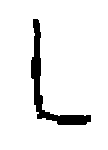

vhu
---------------


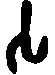

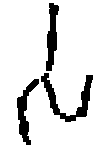

sa
---------------


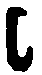

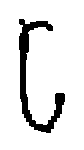

paa
---------------


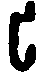

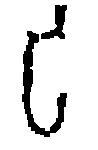

pii
---------------


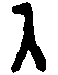

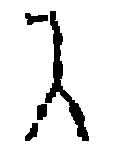

the
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


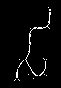

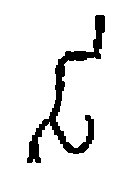

Skeletonization
----------------------------------------------------


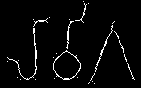

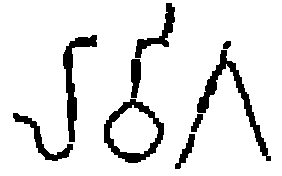

Skeletonization
----------------------------------------------------


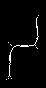

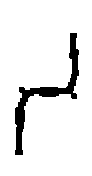

Skeletonization
----------------------------------------------------


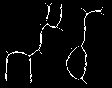

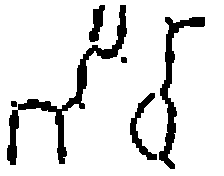

Skeletonization
----------------------------------------------------


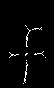

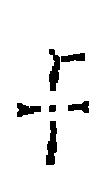

Skeletonization
----------------------------------------------------


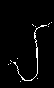

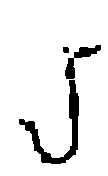

Skeletonization
----------------------------------------------------


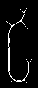

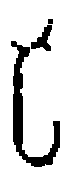

Skeletonization
----------------------------------------------------


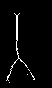

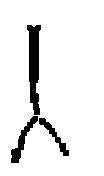

Skeletonization
----------------------------------------------------


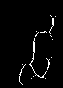

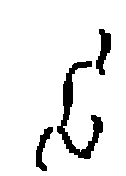

Skeletonization
----------------------------------------------------


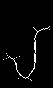

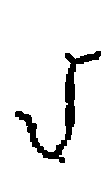

Skeletonization
----------------------------------------------------


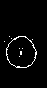

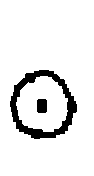

Skeletonization
----------------------------------------------------


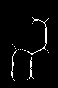

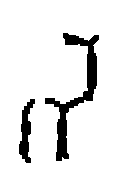

Skeletonization
----------------------------------------------------


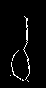

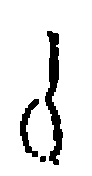

(14, 75, 75, 3)
1/1 [==============================] - 0s 329ms/step
---------------


ee
---------------


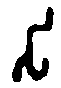

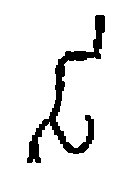

si
---------------


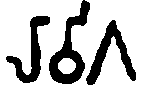

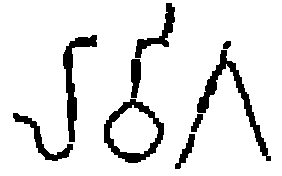

thaii
---------------


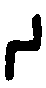

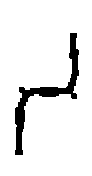

de
---------------


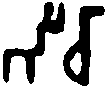

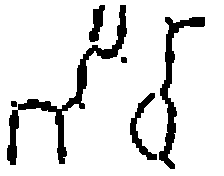

daii
---------------


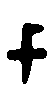

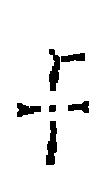

kaa
---------------


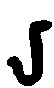

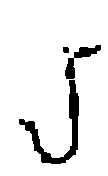

vaa
---------------


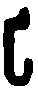

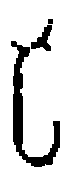

tao
---------------


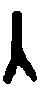

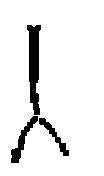

thu
---------------


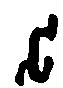

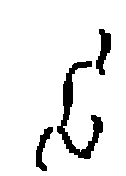

ya(2)
---------------


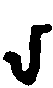

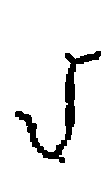

laa
---------------


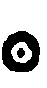

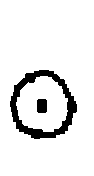

thaa
---------------


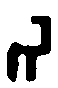

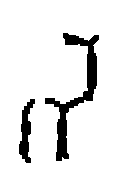

da(2)
---------------


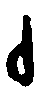

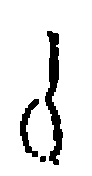

va
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


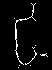

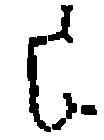

Skeletonization
----------------------------------------------------


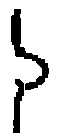

Skeletonization
----------------------------------------------------


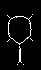

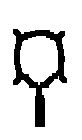

Skeletonization
----------------------------------------------------


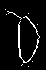

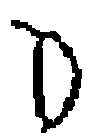

Skeletonization
----------------------------------------------------


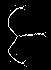

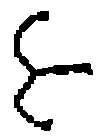

Skeletonization
----------------------------------------------------


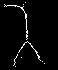

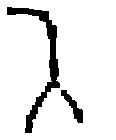

(7, 75, 75, 3)
1/1 [==============================] - 0s 359ms/step
---------------


ee
---------------


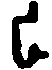

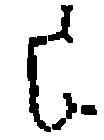

pii
---------------


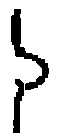

dha
---------------


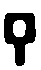

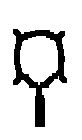

baa
---------------


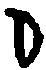

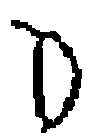

ge
---------------


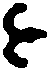

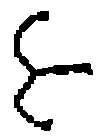

ja
---------------


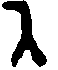

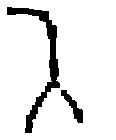

the(2)
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


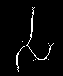

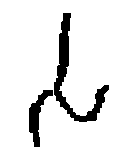

Skeletonization
----------------------------------------------------


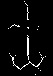

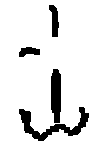

Skeletonization
----------------------------------------------------


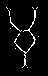

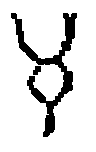

Skeletonization
----------------------------------------------------


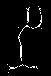

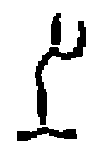

Skeletonization
----------------------------------------------------


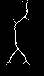

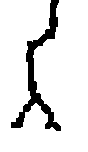

(6, 75, 75, 3)
1/1 [==============================] - 0s 193ms/step
---------------


ee
---------------


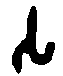

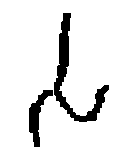

sa
---------------


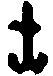

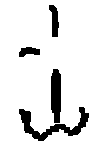

yo(2)
---------------


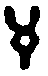

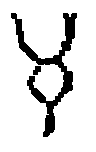

mii
---------------


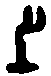

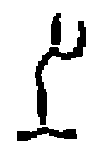

nii
---------------


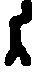

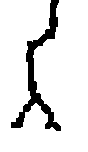

thi
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


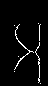

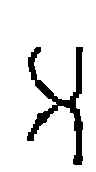

Skeletonization
----------------------------------------------------


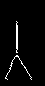

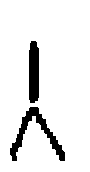

Skeletonization
----------------------------------------------------


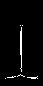

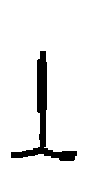

Skeletonization
----------------------------------------------------


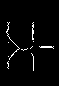

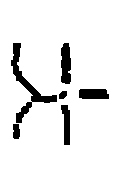

Skeletonization
----------------------------------------------------


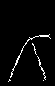

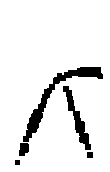

Skeletonization
----------------------------------------------------


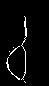

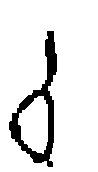

Skeletonization
----------------------------------------------------


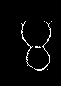

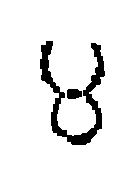

Skeletonization
----------------------------------------------------


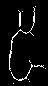

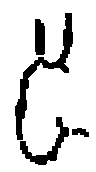

Skeletonization
----------------------------------------------------


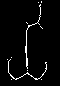

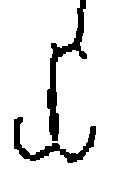

Skeletonization
----------------------------------------------------


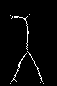

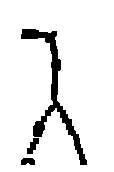

(11, 75, 75, 3)
1/1 [==============================] - 0s 336ms/step
---------------


ee
---------------


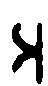

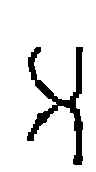

mu
---------------


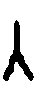

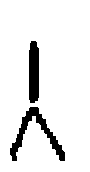

thu
---------------


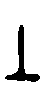

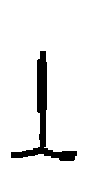

na
---------------


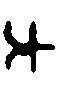

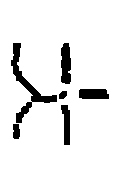

thu
---------------


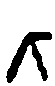

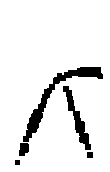

da(2)
---------------


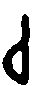

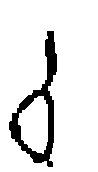

va
---------------


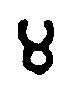

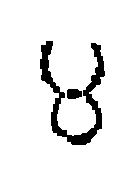

thao
---------------


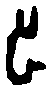

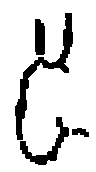

va
---------------


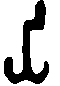

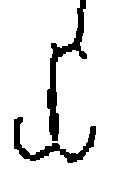

yo(2)
---------------


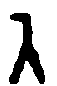

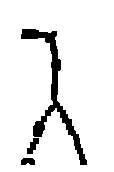

the(2)
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


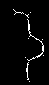

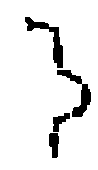

Skeletonization
----------------------------------------------------


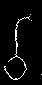

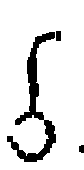

Skeletonization
----------------------------------------------------


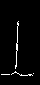

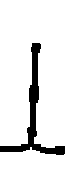

Skeletonization
----------------------------------------------------


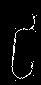

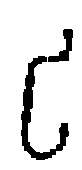

Skeletonization
----------------------------------------------------


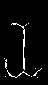

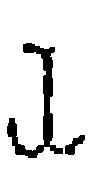

Skeletonization
----------------------------------------------------


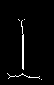

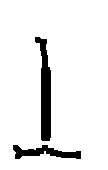

Skeletonization
----------------------------------------------------


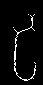

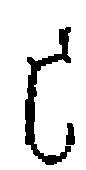

Skeletonization
----------------------------------------------------


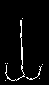

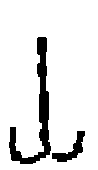

Skeletonization
----------------------------------------------------


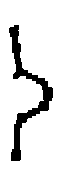

Skeletonization
----------------------------------------------------


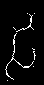

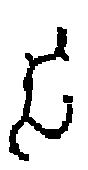

Skeletonization
----------------------------------------------------


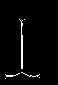

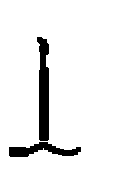

Skeletonization
----------------------------------------------------


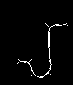

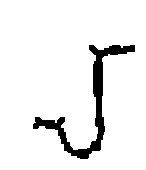

Skeletonization
----------------------------------------------------


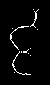

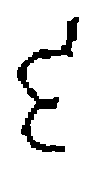

Skeletonization
----------------------------------------------------


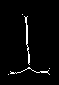

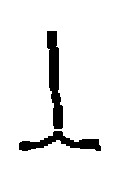

Skeletonization
----------------------------------------------------


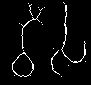

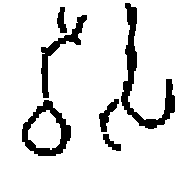

Skeletonization
----------------------------------------------------


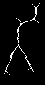

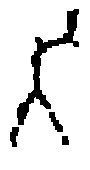

Skeletonization
----------------------------------------------------


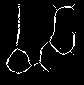

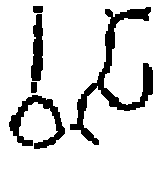

Skeletonization
----------------------------------------------------


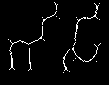

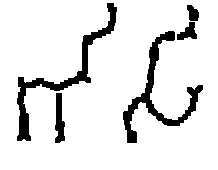

Skeletonization
----------------------------------------------------


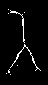

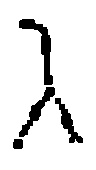

Skeletonization
----------------------------------------------------


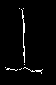

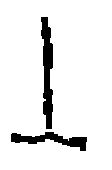

(21, 75, 75, 3)
1/1 [==============================] - 1s 672ms/step
---------------


ee
---------------


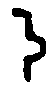

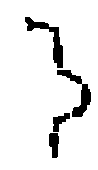

dho
---------------


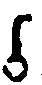

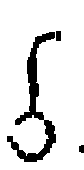

vaa
---------------


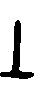

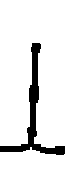

na
---------------


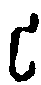

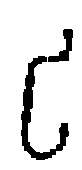

pi
---------------


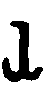

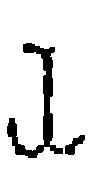

yo(2)
---------------


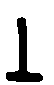

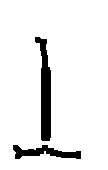

na
---------------


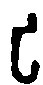

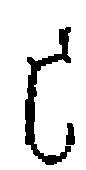

pi
---------------


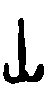

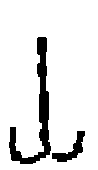

sa
---------------


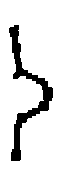

dha
---------------


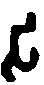

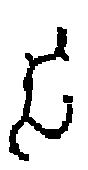

sii
---------------


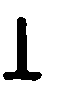

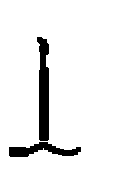

na
---------------


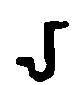

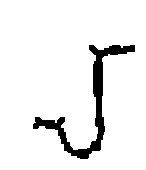

laa
---------------


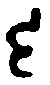

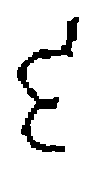

ji
---------------


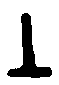

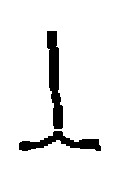

na
---------------


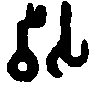

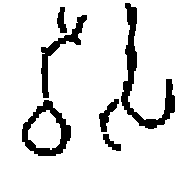

phii
---------------


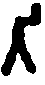

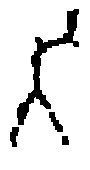

thii
---------------


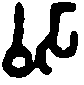

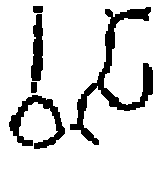

sa(2)
---------------


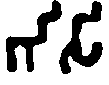

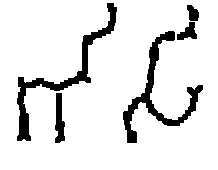

ghi
---------------


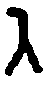

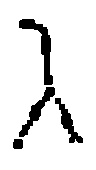

the
---------------


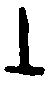

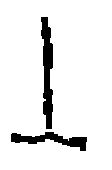

na


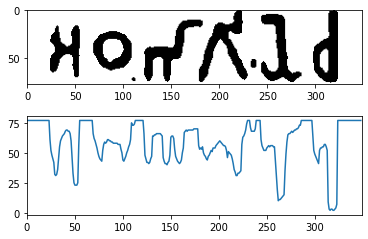

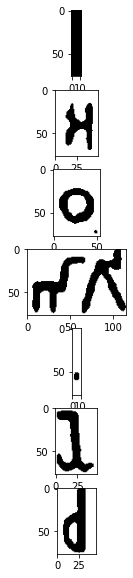

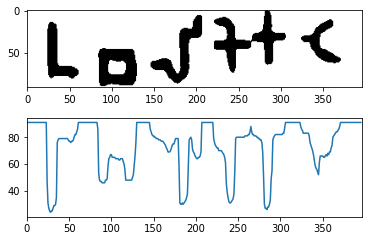

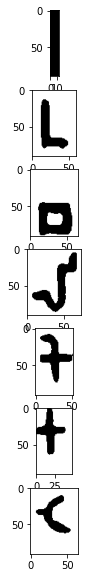

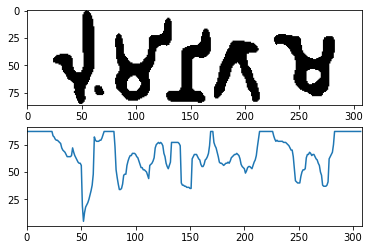

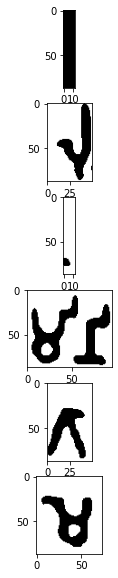

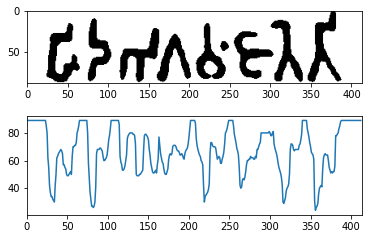

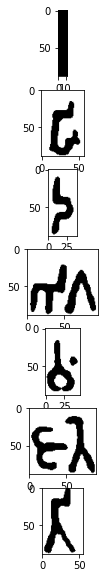

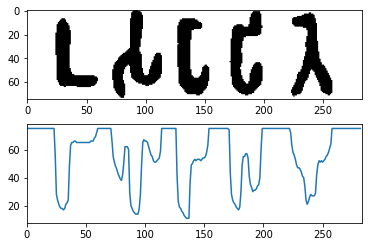

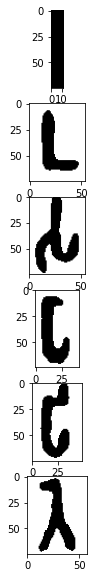

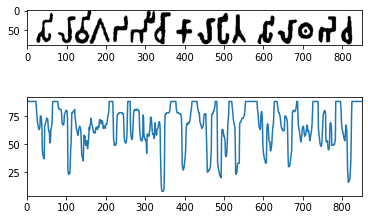

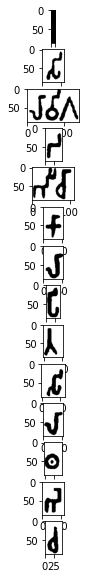

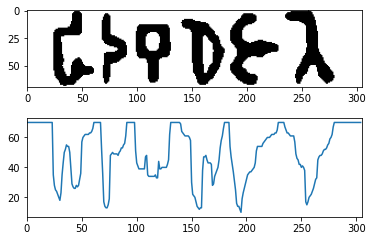

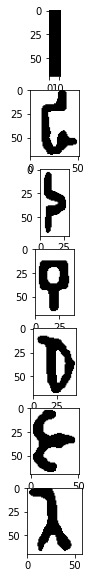

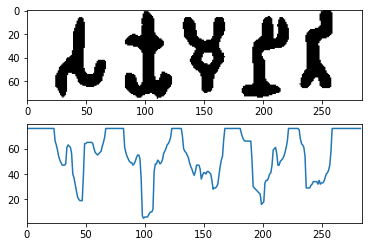

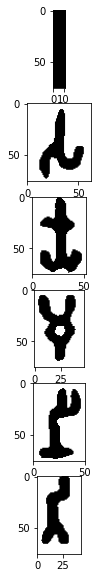

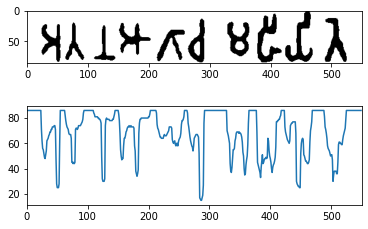

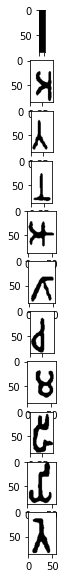

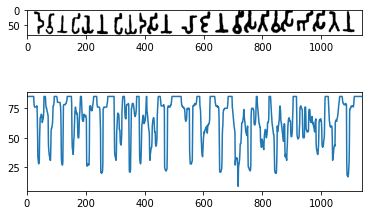

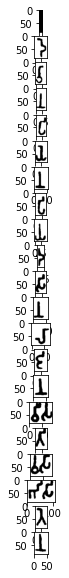

In [12]:
char_seg_height = 15
blurring = 5
img = cv2.imread('/content/drive/MyDrive/Capstone Project/Research Papers/Images/new_images/b1.jpg')
cv2_imshow(img) 
img = cv2.resize(img, (5*img.shape[1], 5*img.shape[0]))
cc_img = connectedcomp(img,blurring)
#cc_img_resize = cv2.resize(cc_img, (3 * cc_img.shape[1], 3 * cc_img.shape[0]))
cv2_imshow(cc_img)
cc_img_1 = check_invert(cc_img)
cv2_imshow(cc_img_1) 
lines = lineseg(cc_img_1)
print(len(lines))
for i in lines:
  thinned_line = line_thinning(i)
  res_chars = charseg(thinned_line,char_seg_height)
  res_skel=[]
  for j in res_chars:
    temp_image = skeletonize1(j)
    res_skel.append(prune(temp_image))
  res_arr = predict_chars(res_skel)
  for k in range(len(res_skel)):
    print('---------------')
    cv2_imshow(res_chars[k])
    cv2_imshow(res_skel[k])
    print(res_arr[k])

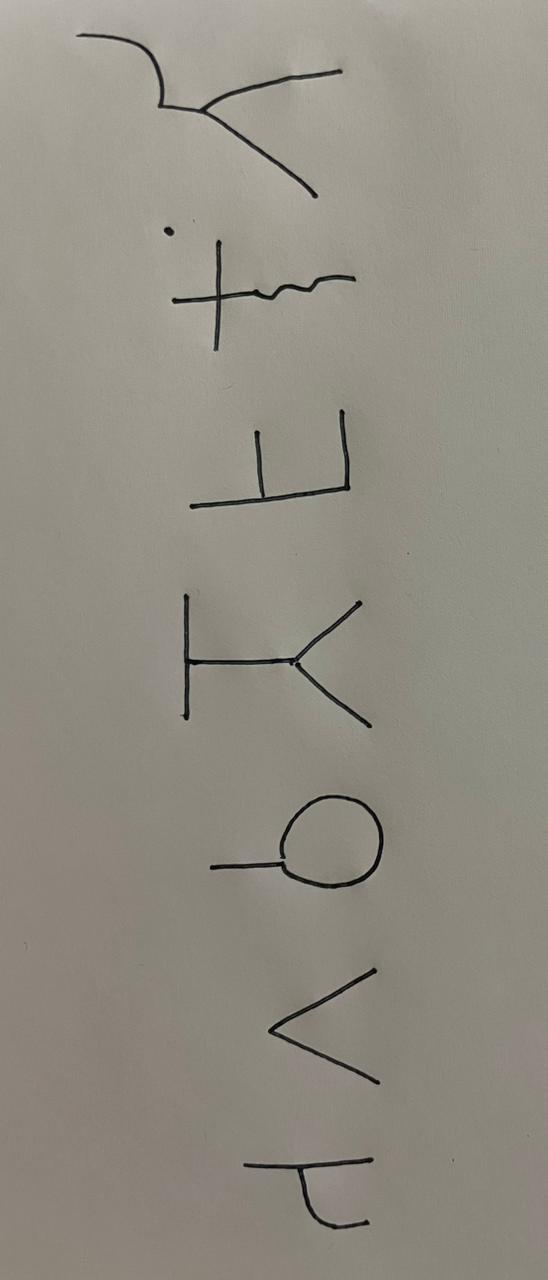

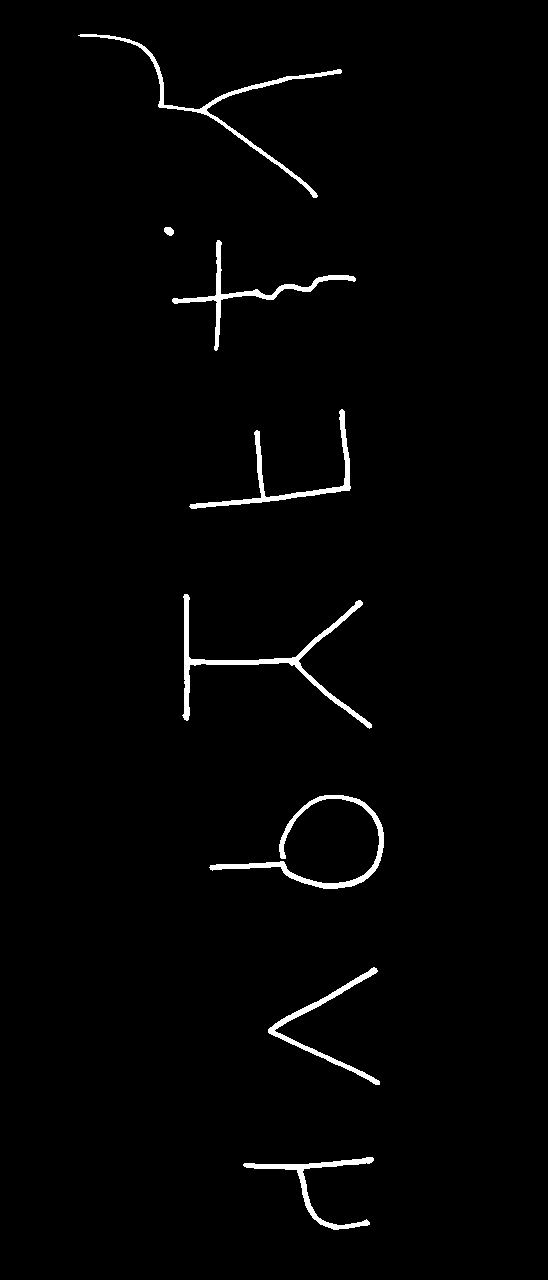

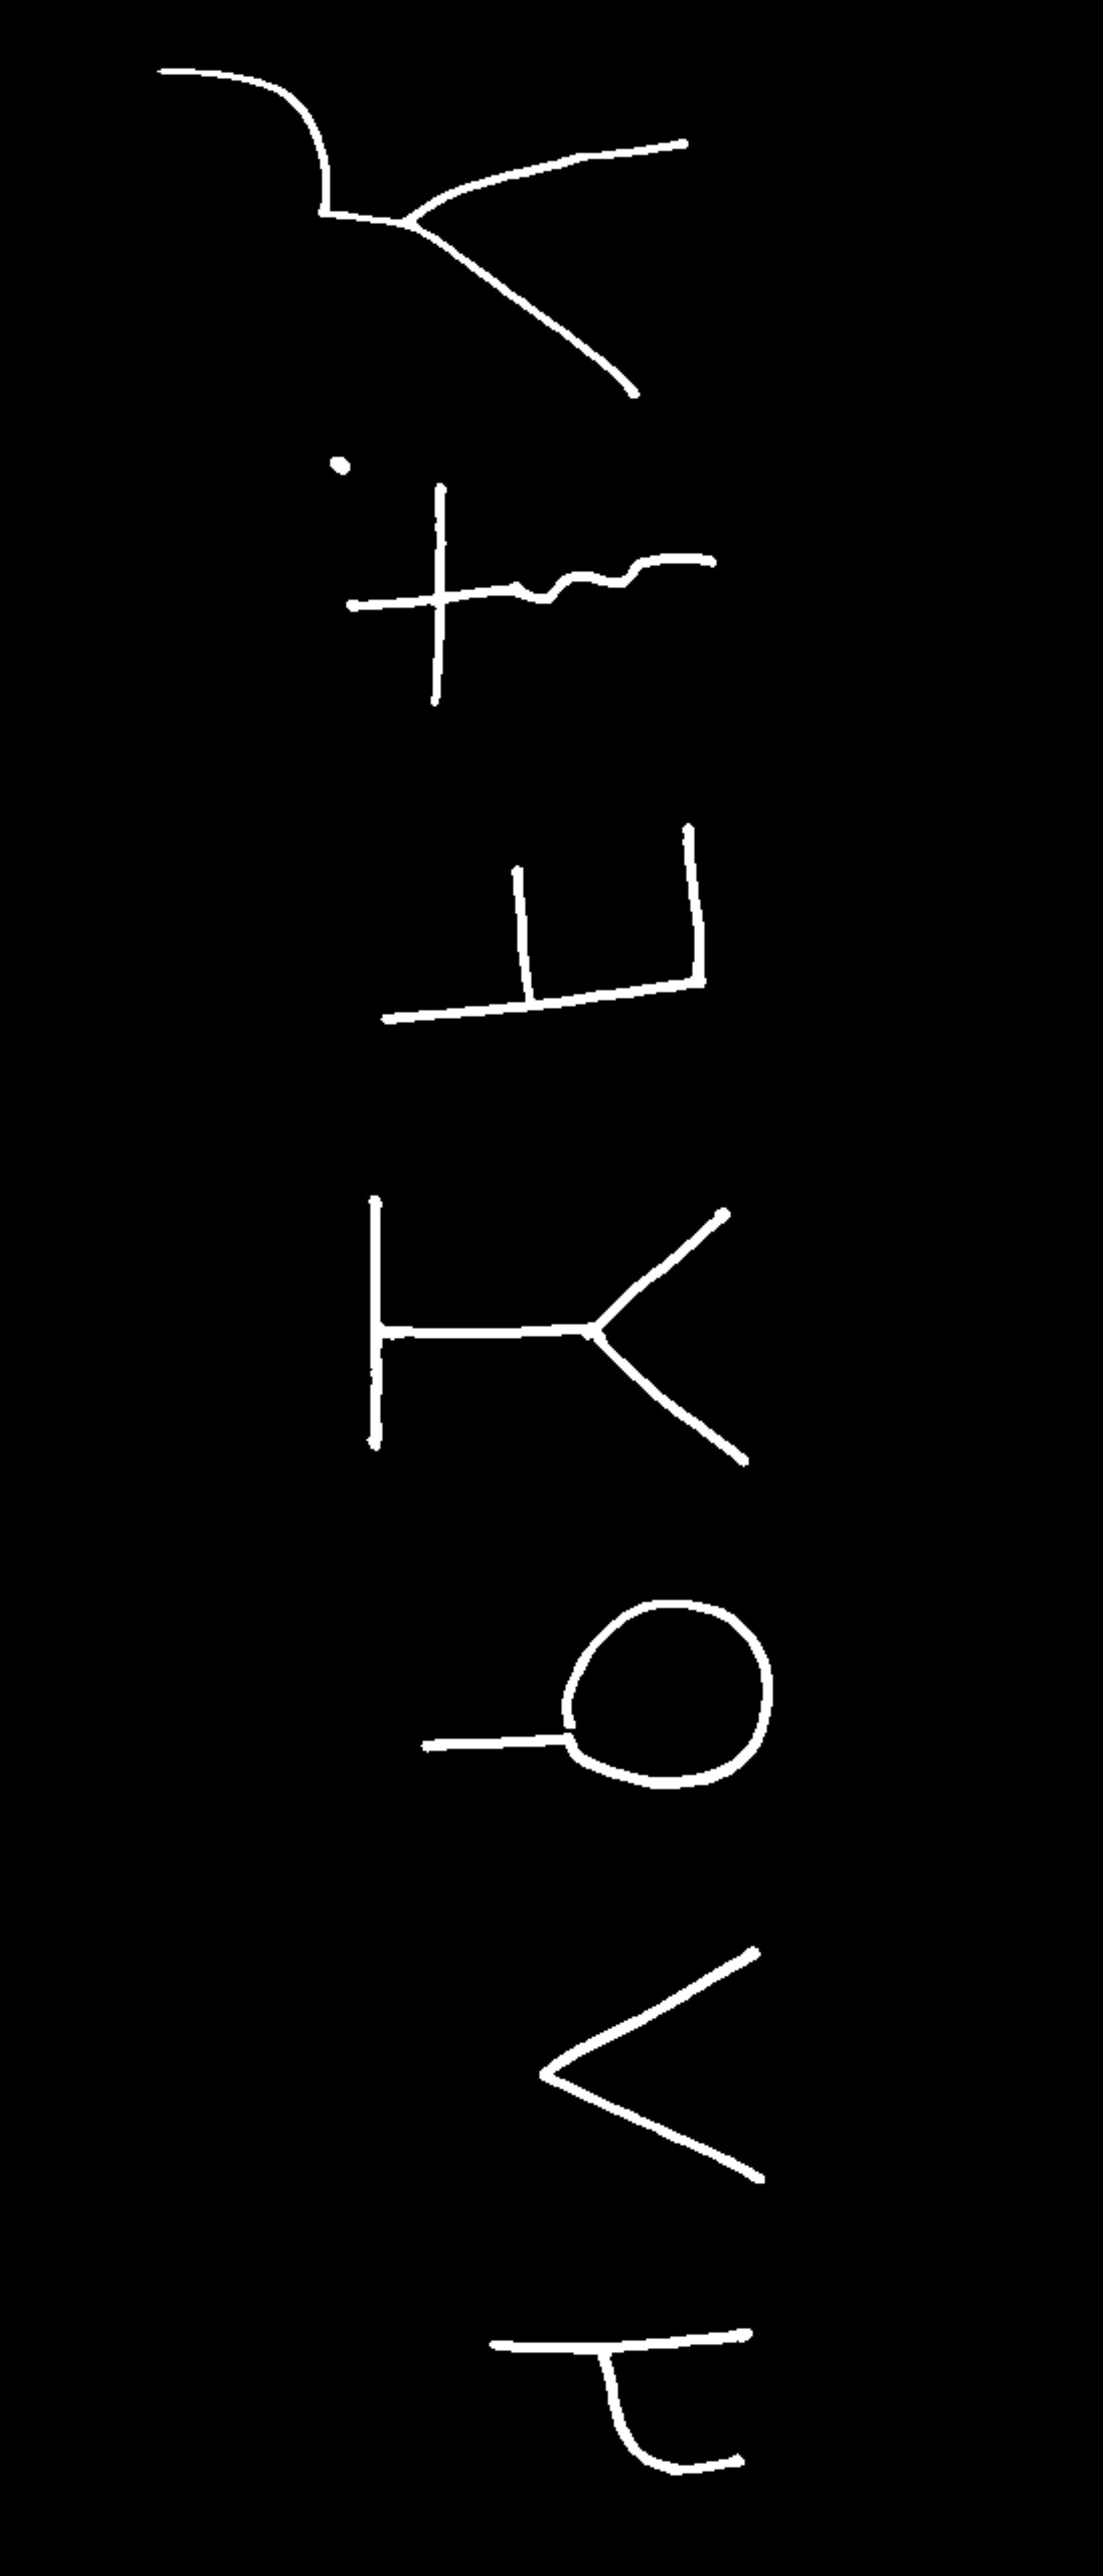

KeyboardInterrupt: ignored

In [13]:
char_seg_height = 15
blurring = 5
img = cv2.imread('/content/drive/MyDrive/Capstone Project/handwritten inscriptions/1.jpg')
cv2_imshow(img) 
#img = cv2.resize(img, (5*img.shape[1], 5*img.shape[0]))
cc_img = connectedcomp(img,blurring)
cc_img_resize = cv2.resize(cc_img, (3 * cc_img.shape[1], 3 * cc_img.shape[0]))
cv2_imshow(cc_img_resize)
cc_img_1 = check_invert(cc_img_resize)
cv2_imshow(cc_img_1) 
lines = lineseg(cc_img_1)
print(len(lines))
for i in lines:
  thinned_line = line_thinning(i)
  res_chars = charseg(thinned_line,char_seg_height)
  res_skel=[]
  for j in res_chars:
    temp_image = skeletonize1(j)
    res_skel.append(prune(temp_image))
  res_arr = predict_chars(res_skel)
  for k in range(len(res_skel)):
    print('---------------')
    cv2_imshow(res_chars[k])
    cv2_imshow(res_skel[k])
    print(res_arr[k])

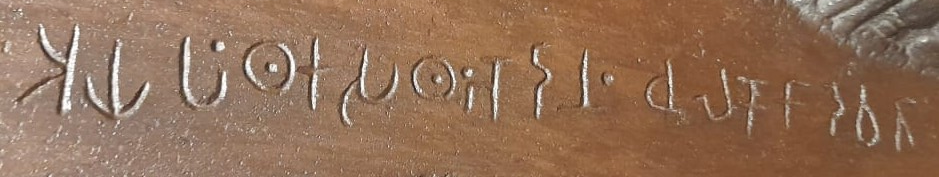

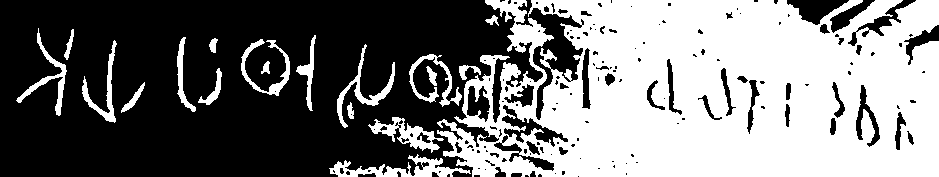

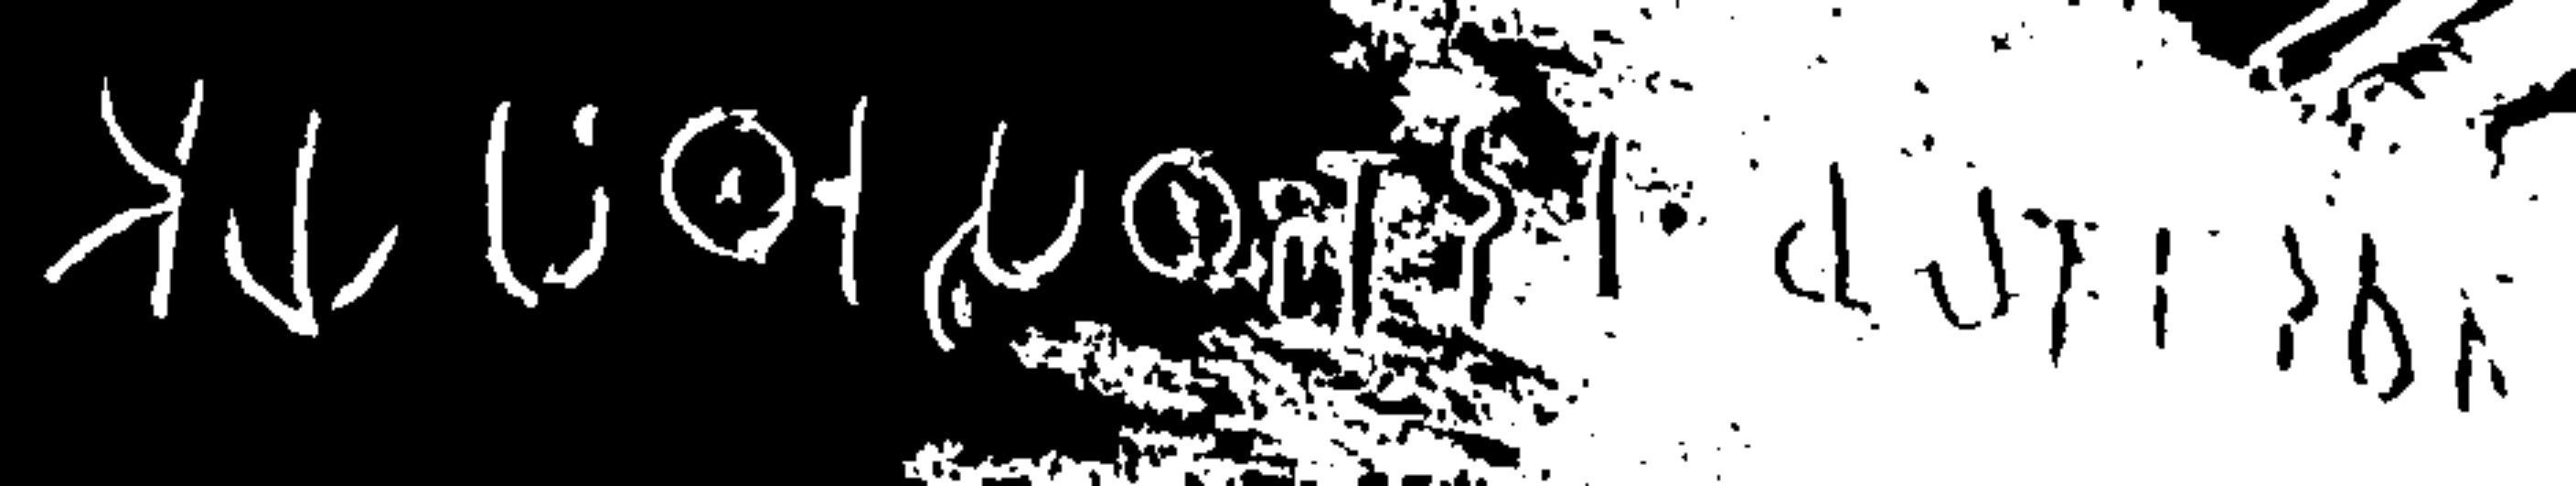

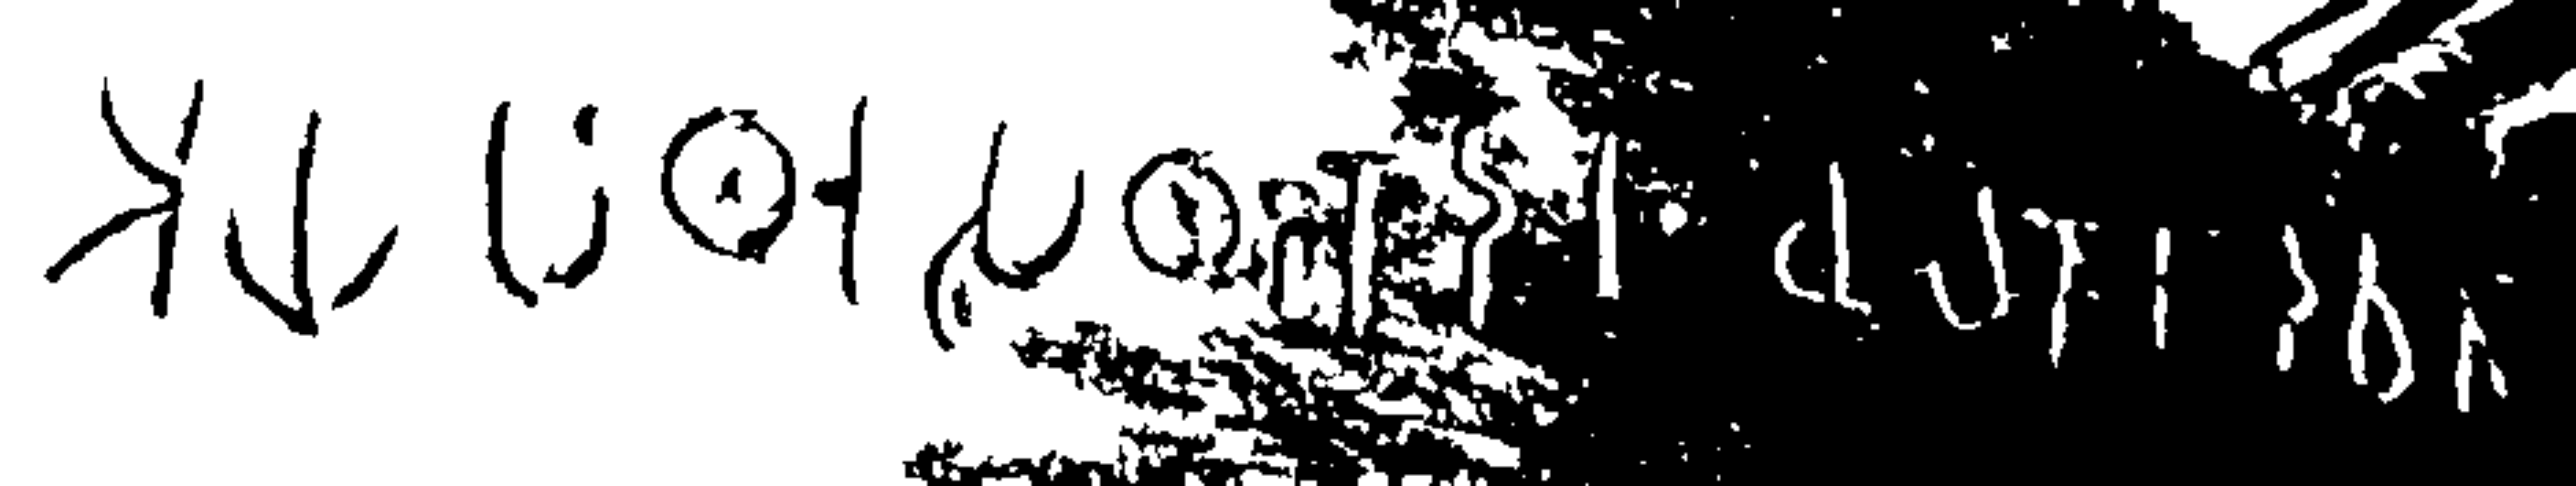

Line seg
----------------------------------------------------


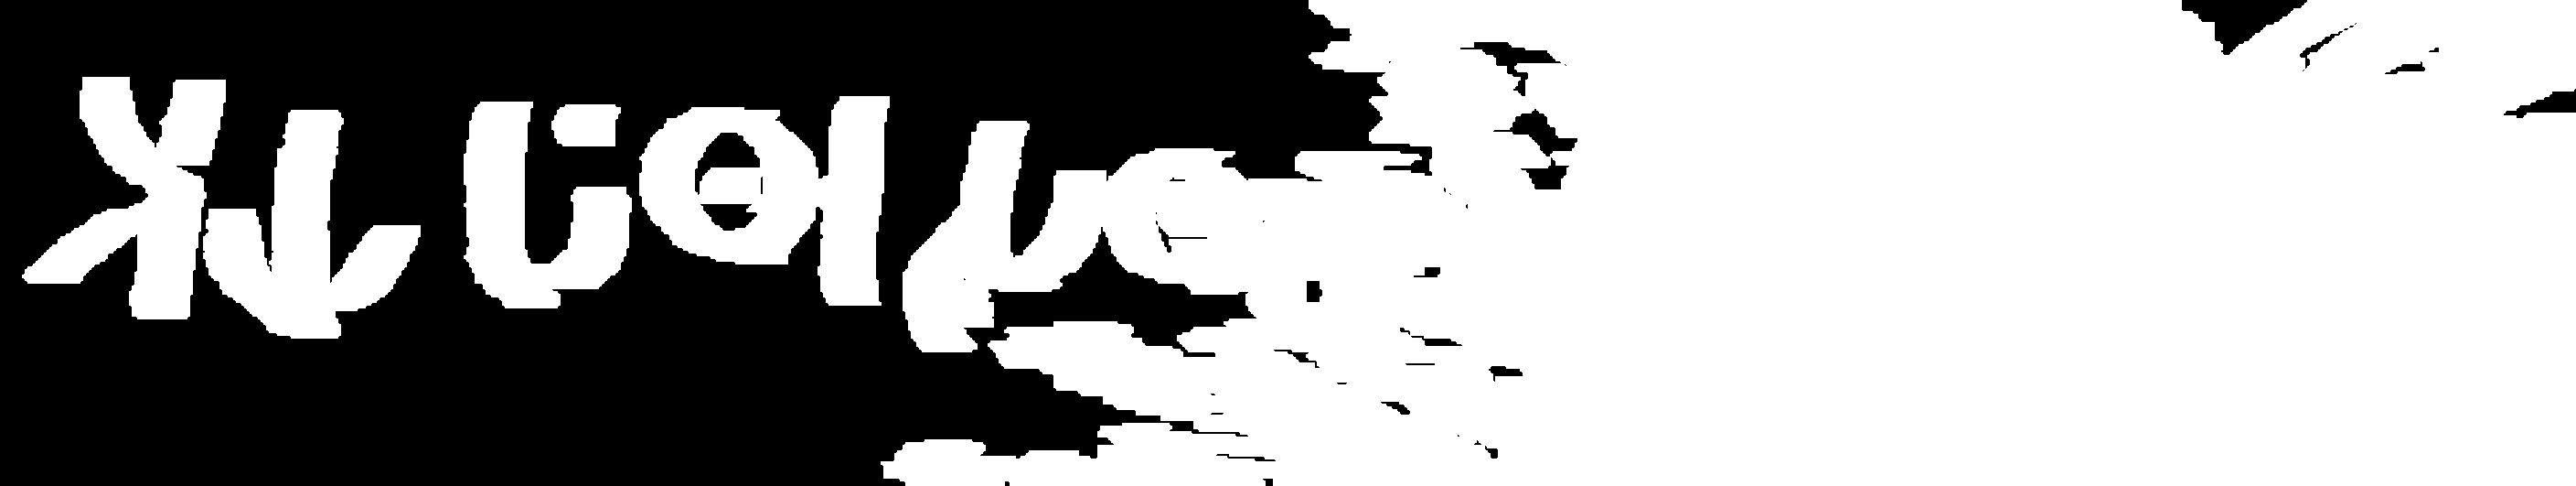

After mask


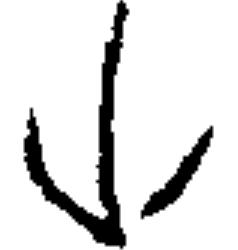

Lines


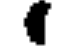

Lines


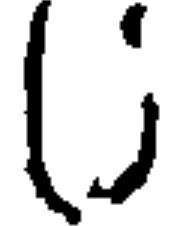

Lines


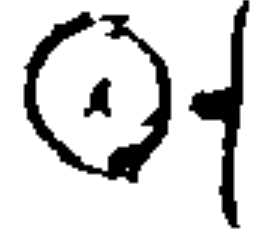

Lines


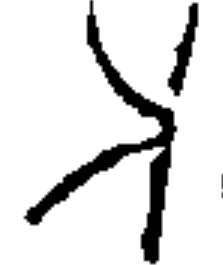

Lines


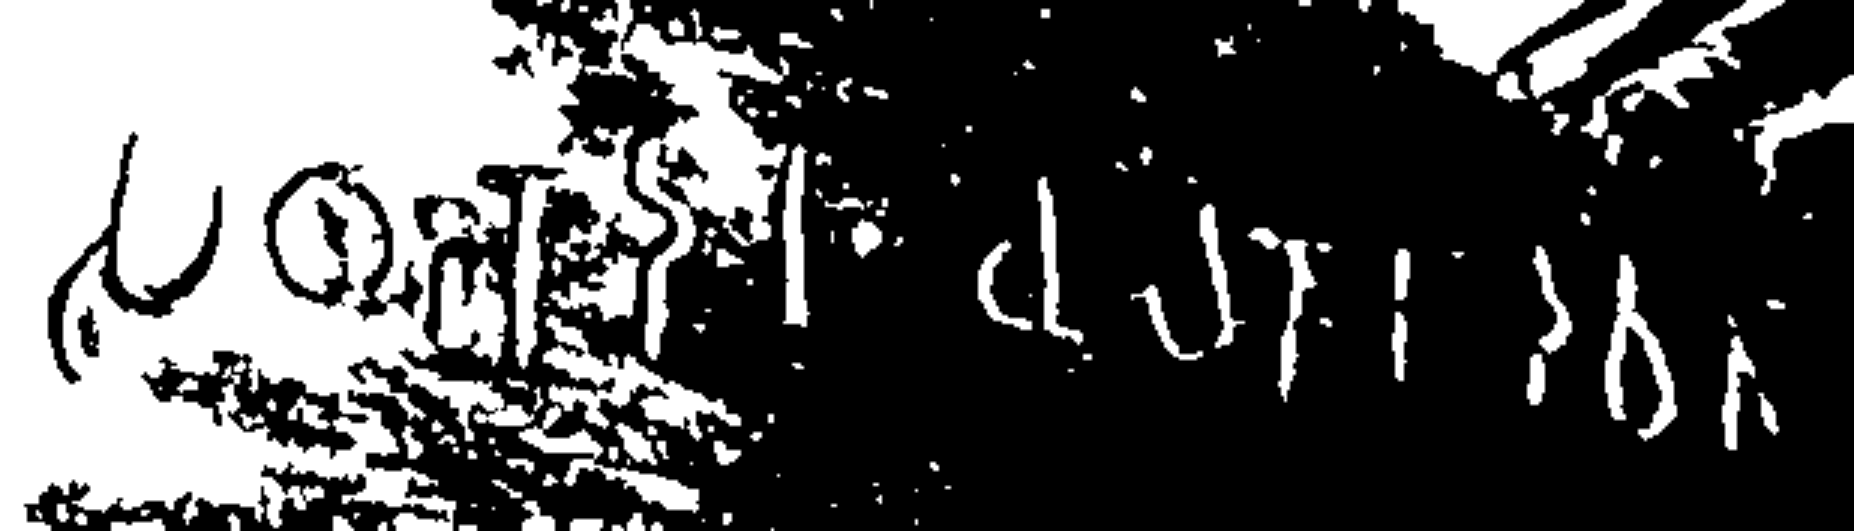

Lines
6
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


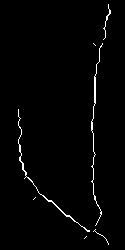

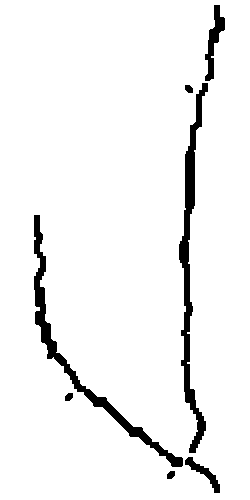

Skeletonization
----------------------------------------------------


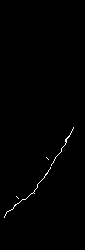

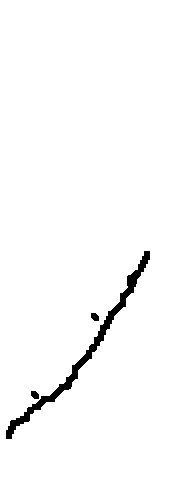

(3, 75, 75, 3)
1/1 [==============================] - 0s 289ms/step
---------------


ee
---------------


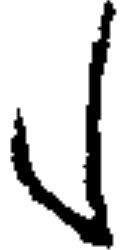

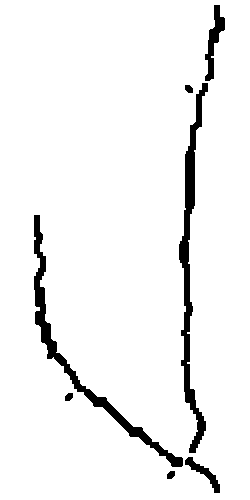

sa(2)
---------------


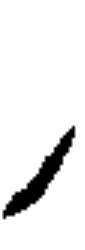

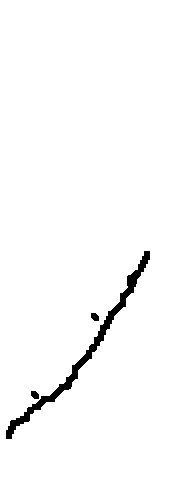

da(2)
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


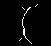

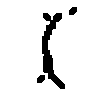

(2, 75, 75, 3)
1/1 [==============================] - 0s 107ms/step
---------------


ee
---------------


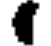

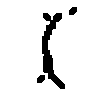

thaaa
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


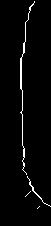

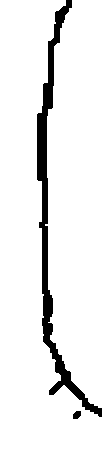

Skeletonization
----------------------------------------------------


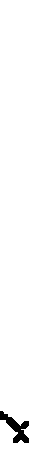

Skeletonization
----------------------------------------------------


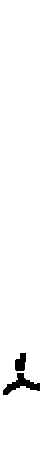

Skeletonization
----------------------------------------------------


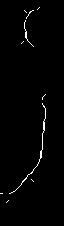

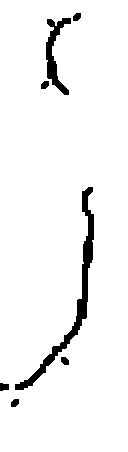

(5, 75, 75, 3)
1/1 [==============================] - 0s 189ms/step
---------------


ee
---------------


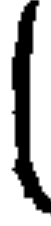

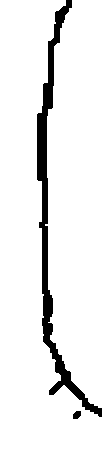

o(2)
---------------


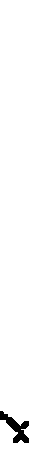

na(2)
---------------


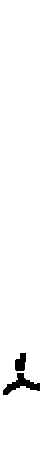

ju
---------------


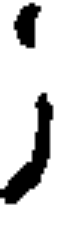

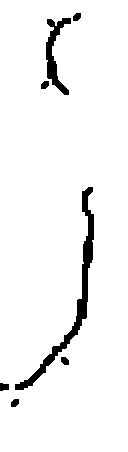

dii
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


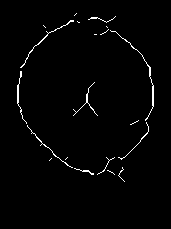

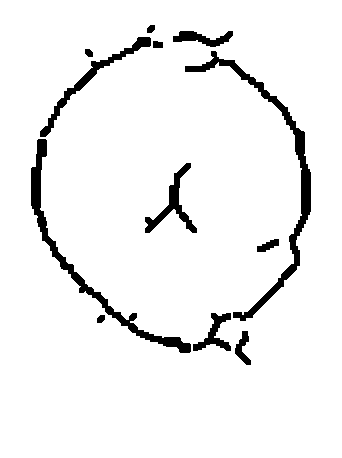

Skeletonization
----------------------------------------------------


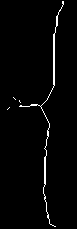

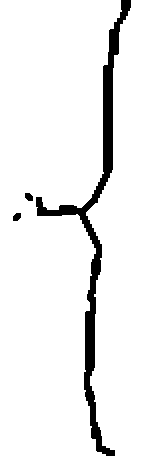

(3, 75, 75, 3)
1/1 [==============================] - 0s 129ms/step
---------------


ee
---------------


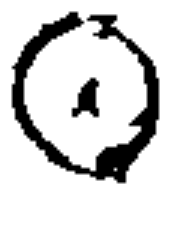

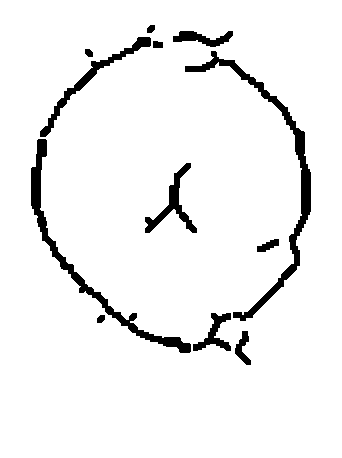

ghi
---------------


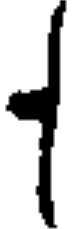

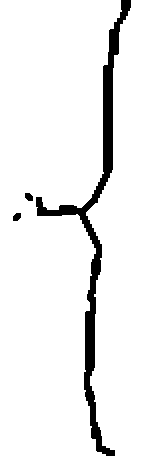

ru
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


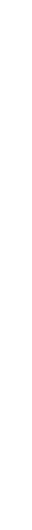

Skeletonization
----------------------------------------------------


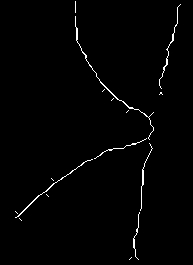

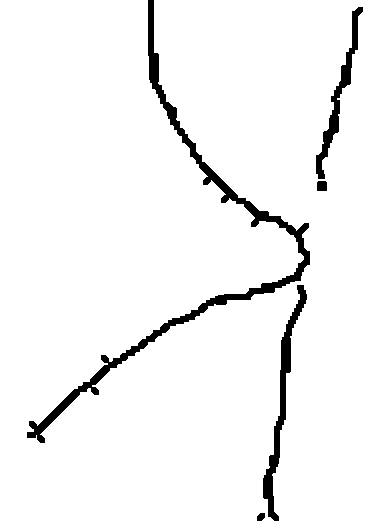

(2, 75, 75, 3)
1/1 [==============================] - 0s 110ms/step
---------------


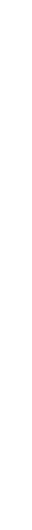

ee
---------------


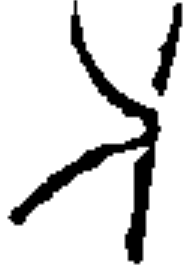

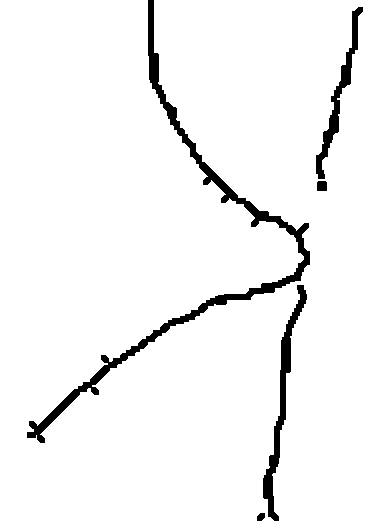

aaa
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


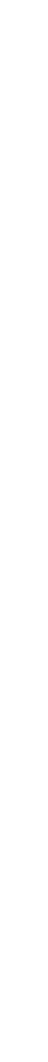

Skeletonization
----------------------------------------------------


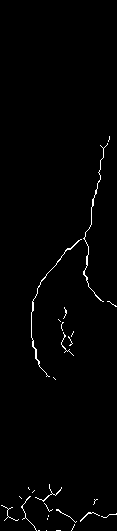

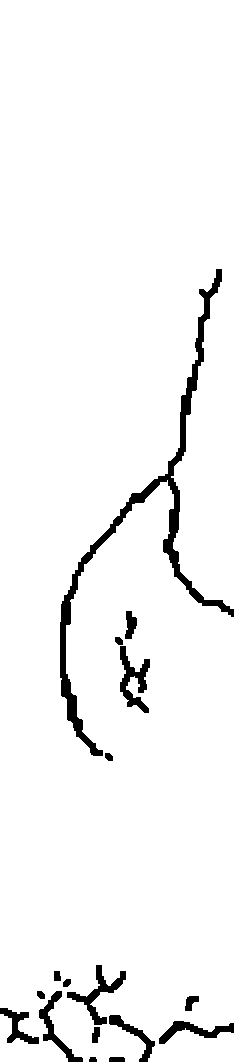

Skeletonization
----------------------------------------------------


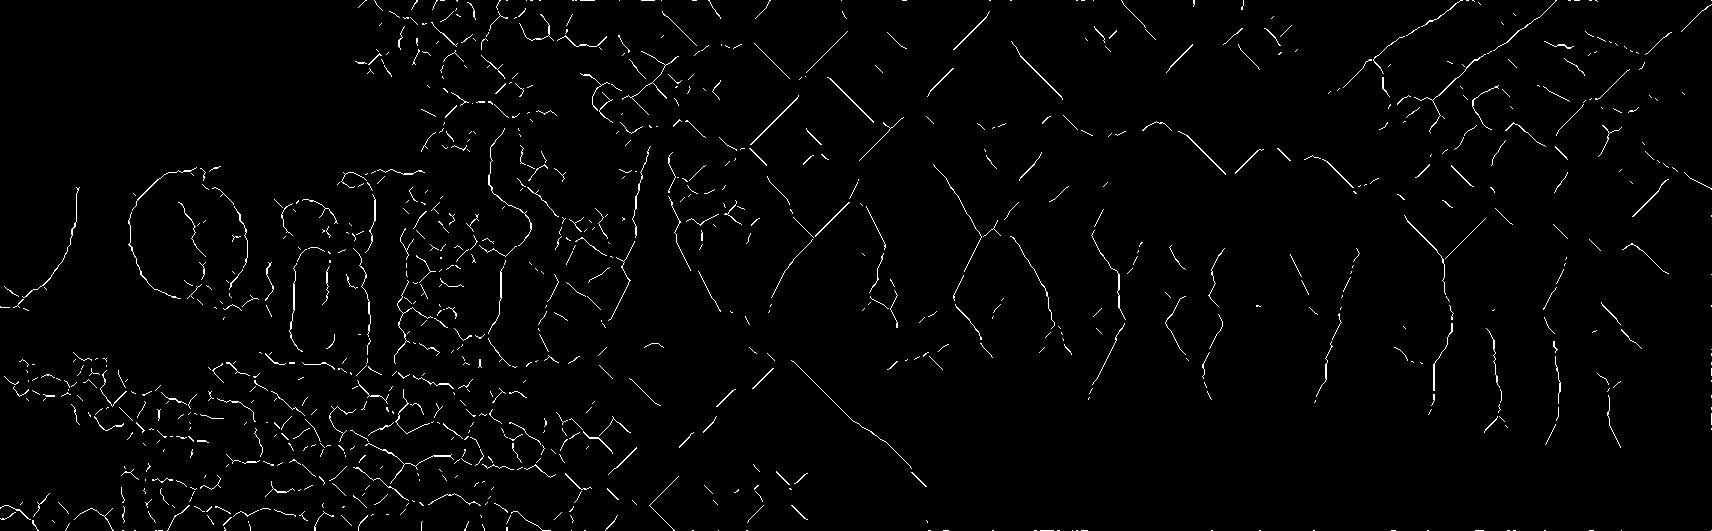

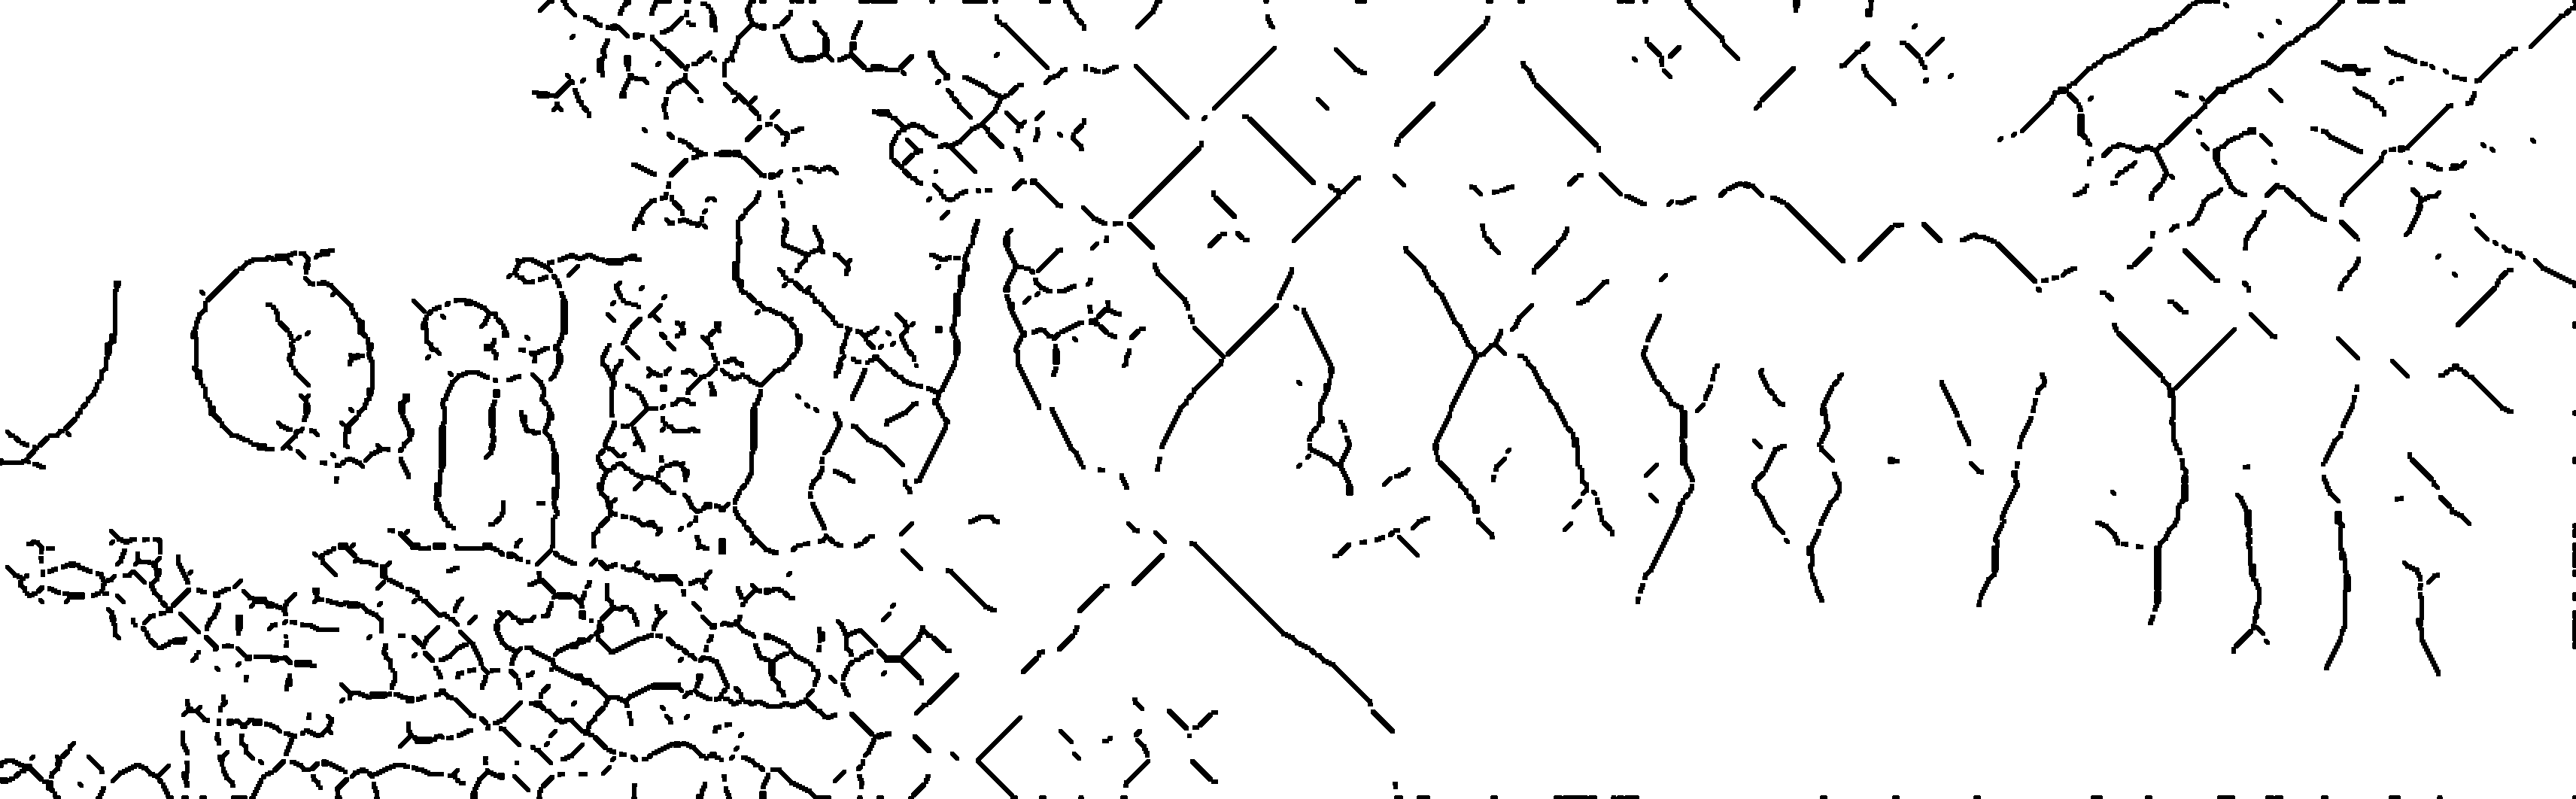

(3, 75, 75, 3)
1/1 [==============================] - 0s 138ms/step
---------------


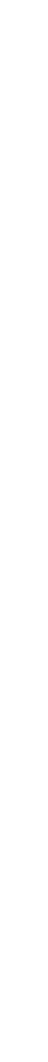

ee
---------------


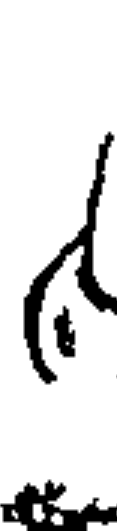

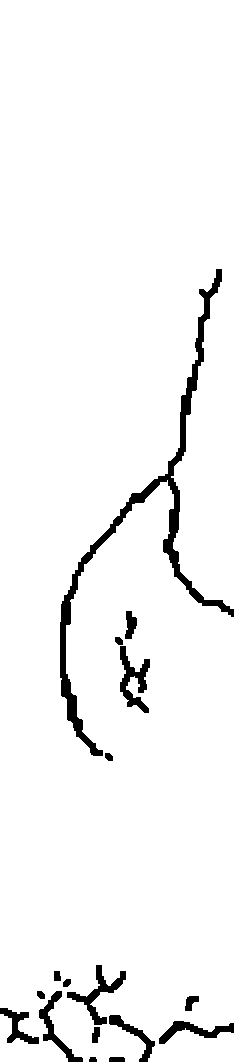

shaii
---------------


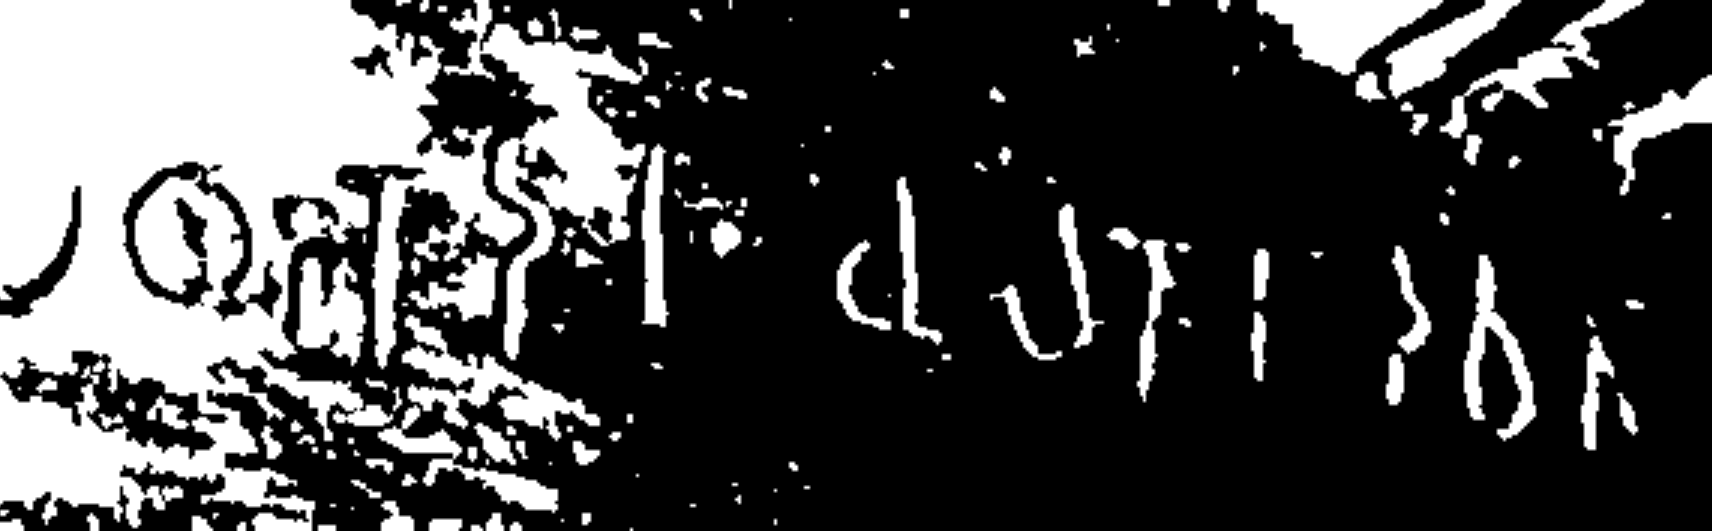

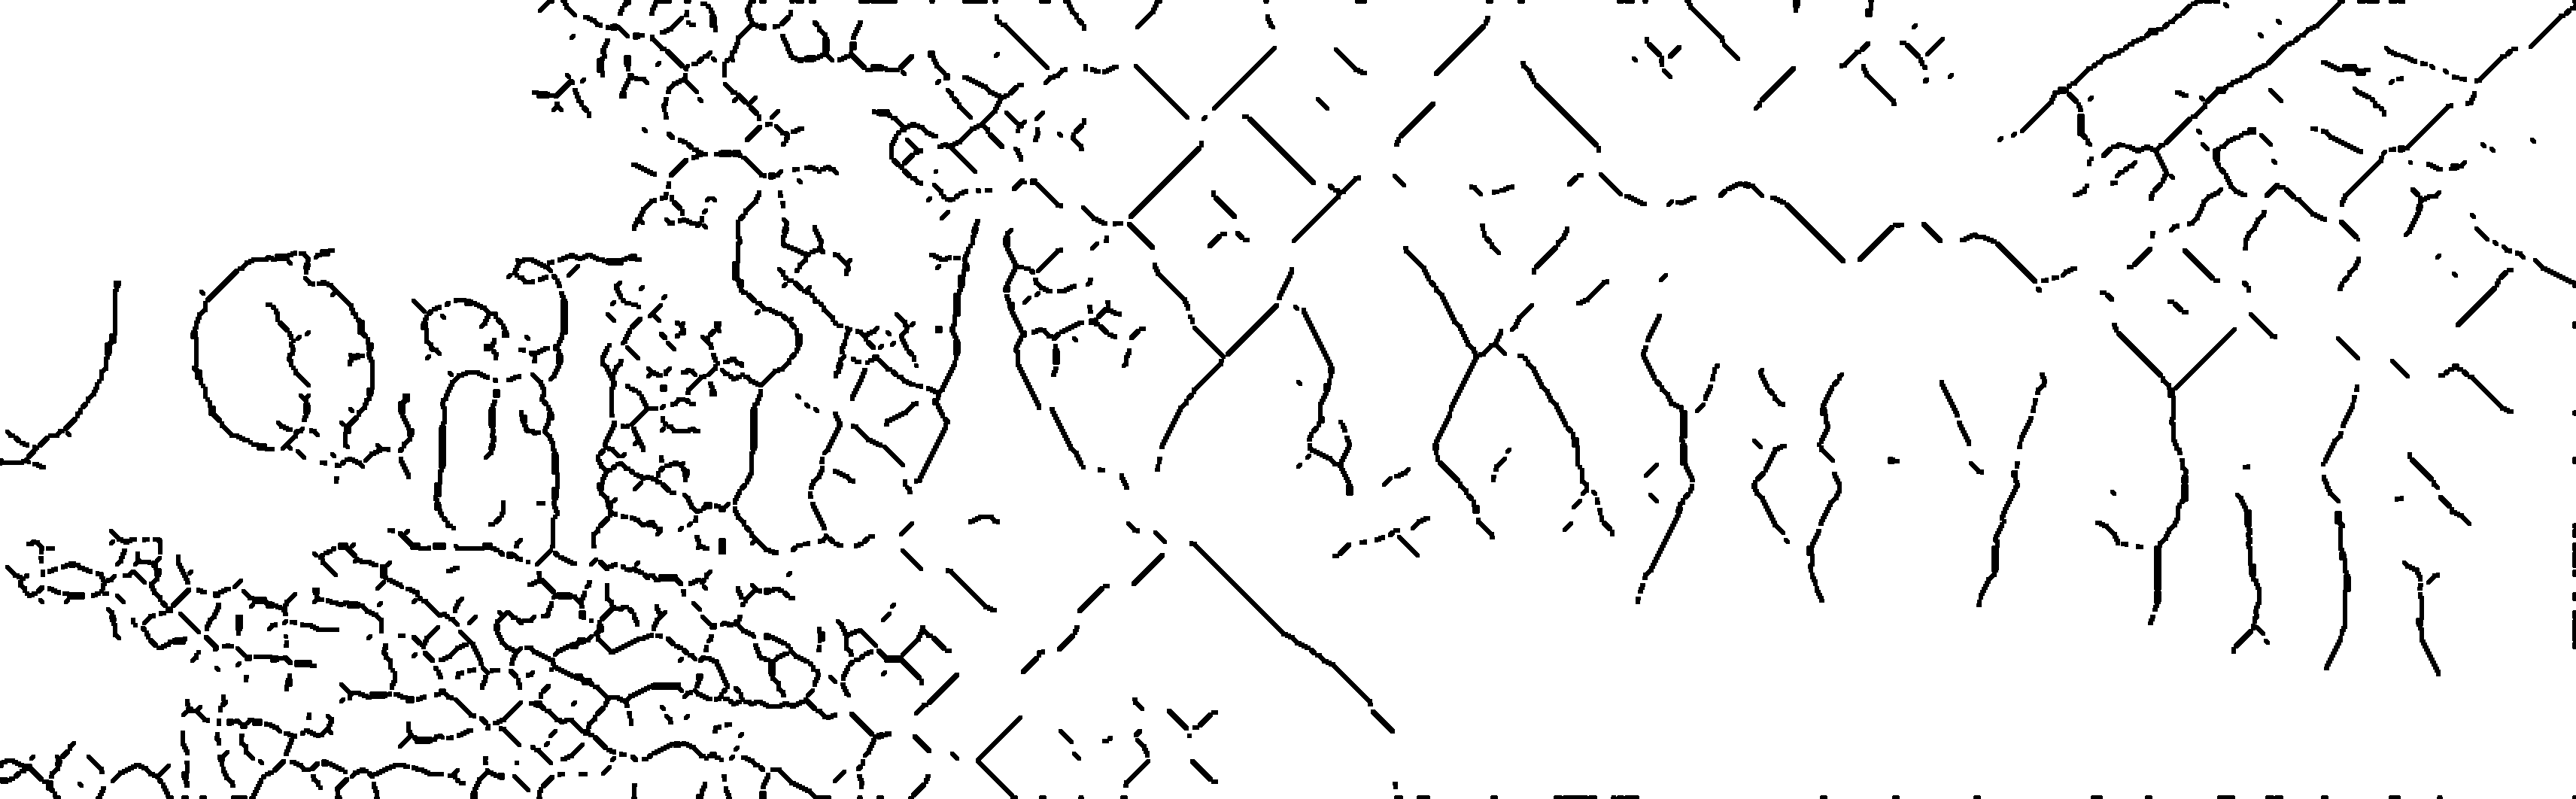

rii


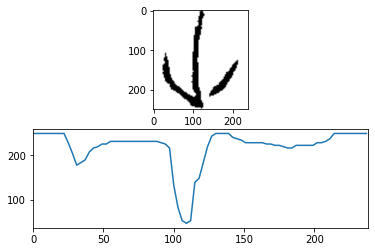

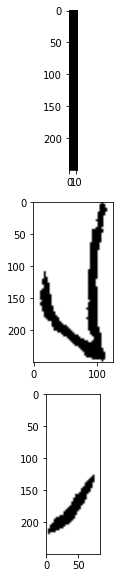

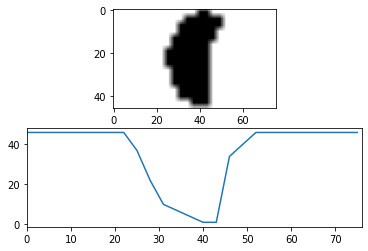

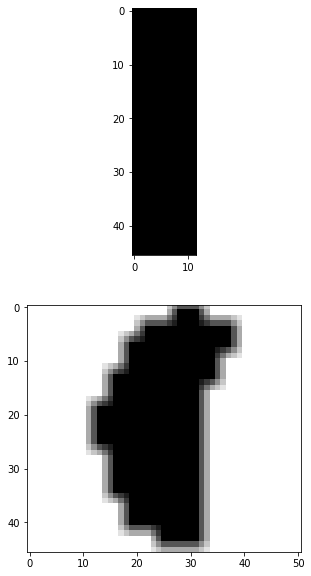

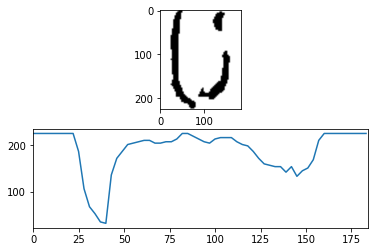

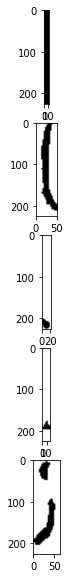

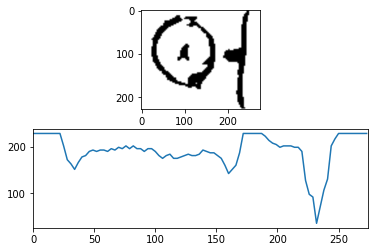

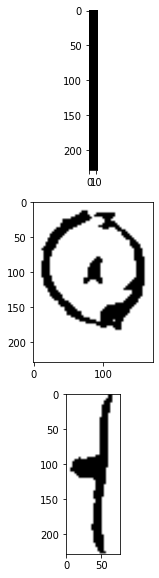

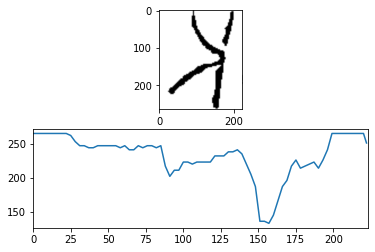

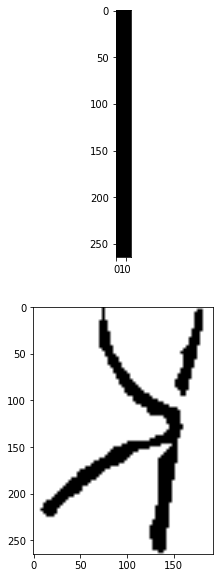

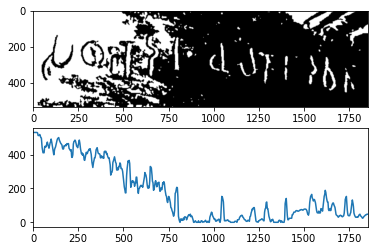

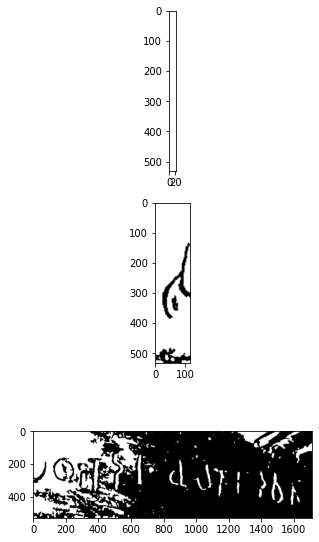

In [ ]:
char_seg_height = 15
blurring = 5
img = cv2.imread('/content/drive/MyDrive/Capstone Project/new_images_kolkata/bk-10.jpeg')
cv2_imshow(img) 
#img = cv2.resize(img, (5*img.shape[1], 5*img.shape[0]))
cc_img = connectedcomp(img,blurring)
cc_img_resize = cv2.resize(cc_img, (3 * cc_img.shape[1], 3 * cc_img.shape[0]))
cv2_imshow(cc_img_resize)
cc_img_1 = check_invert(cc_img_resize)
cv2_imshow(cc_img_1) 
lines = lineseg(cc_img_1)
print(len(lines))
for i in lines:
  thinned_line = line_thinning(i)
  res_chars = charseg(thinned_line,char_seg_height)
  res_skel=[]
  for j in res_chars:
    temp_image = skeletonize1(j)
    res_skel.append(prune(temp_image))
  res_arr = predict_chars(res_skel)
  for k in range(len(res_skel)):
    print('---------------')
    cv2_imshow(res_chars[k])
    cv2_imshow(res_skel[k])
    print(res_arr[k])

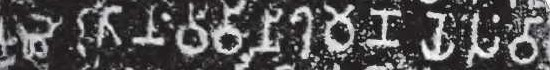

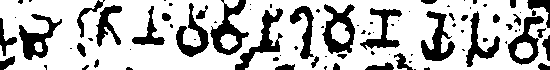

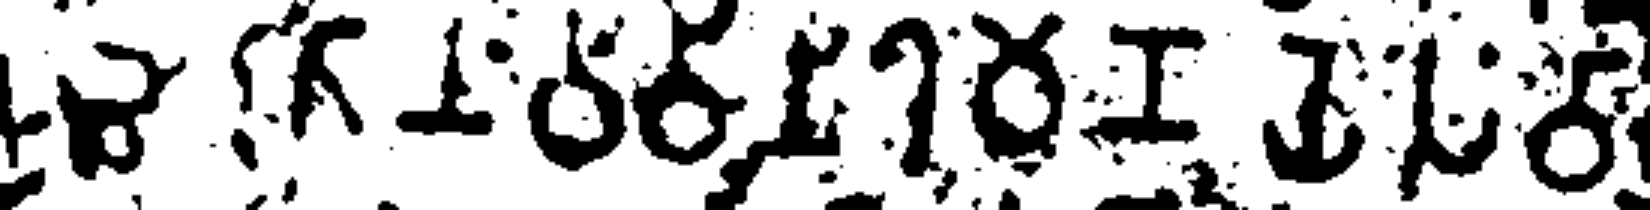

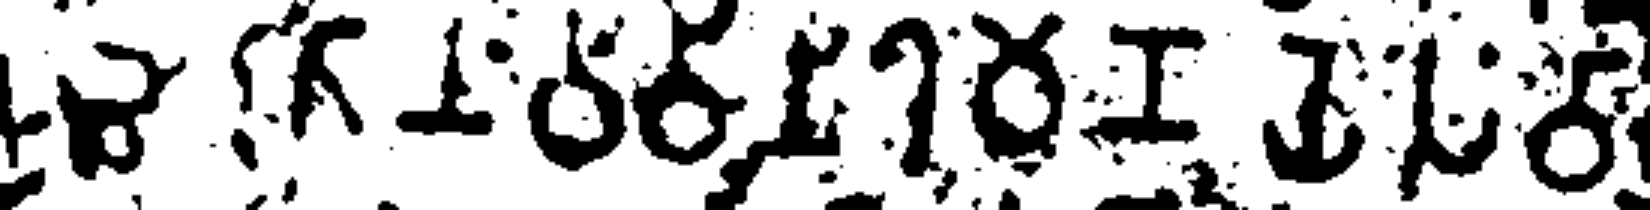

Line seg
----------------------------------------------------


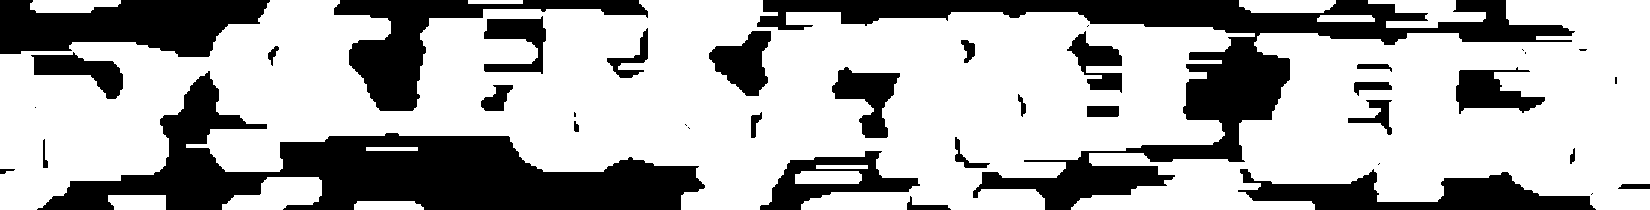

After mask


Lines


Lines


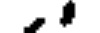

Lines


Lines


Lines


Lines


Lines


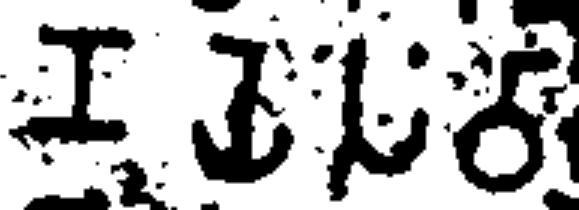

Lines


Lines


Lines


Lines


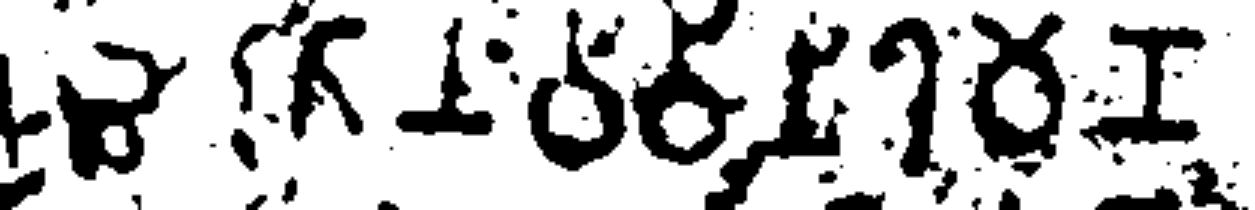

Lines


Lines
13
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 92ms/step
---------------


ee
---------------


ya
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 87ms/step
---------------


ee
---------------


ka
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


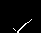

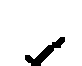

Skeletonization
----------------------------------------------------


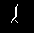

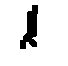

(3, 75, 75, 3)
1/1 [==============================] - 0s 104ms/step
---------------


ee
---------------


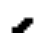

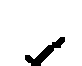

vhu
---------------


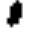

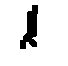

cha
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 86ms/step
---------------


ee
---------------


tha(2)
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 92ms/step
---------------


ee
---------------


ee
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 86ms/step
---------------


ee
---------------


ee
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 89ms/step
---------------


ee
---------------


ka
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


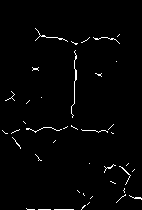

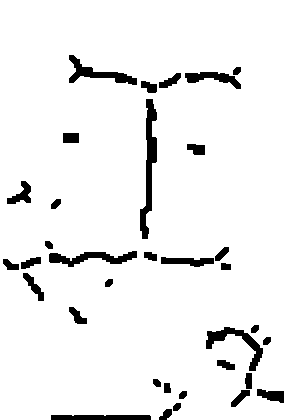

Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


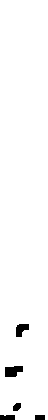

Skeletonization
----------------------------------------------------


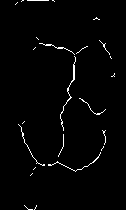

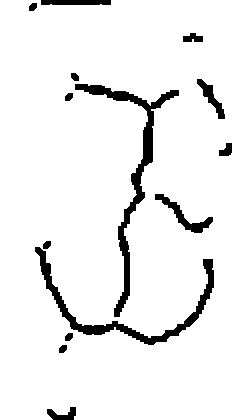

Skeletonization
----------------------------------------------------


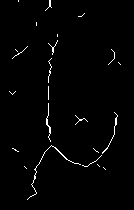

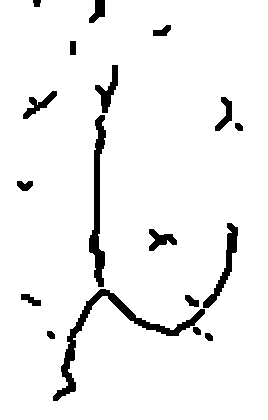

Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


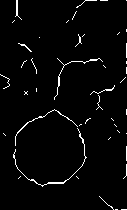

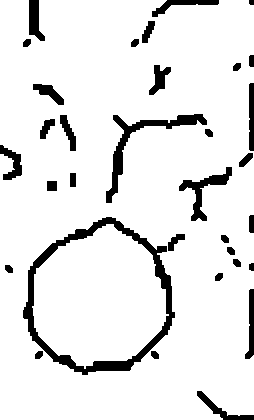

(8, 75, 75, 3)
1/1 [==============================] - 0s 171ms/step
---------------


taaa
---------------


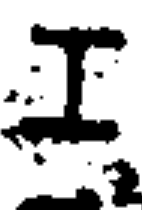

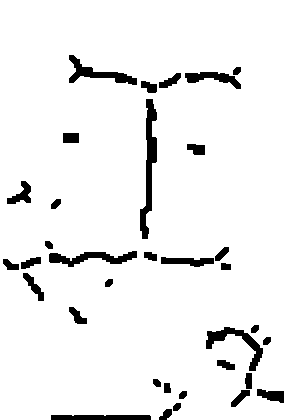

ghuu
---------------


ee
---------------


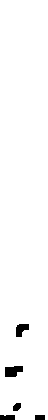

ro
---------------


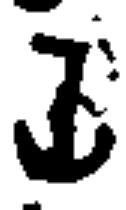

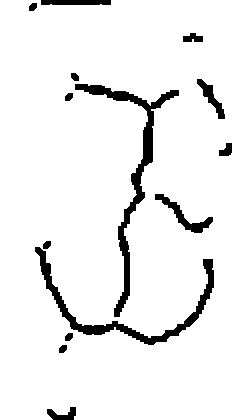

yo(2)
---------------


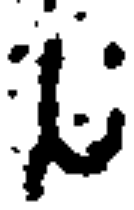

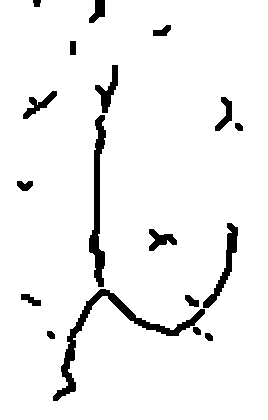

shaaaa
---------------


da(2)
---------------


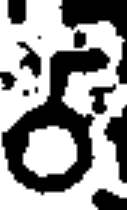

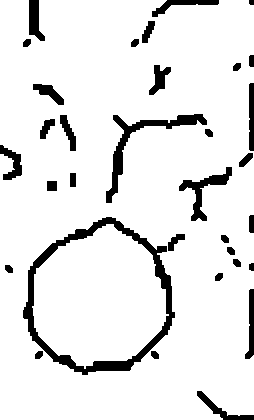

hii
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


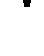

Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


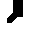

Skeletonization
----------------------------------------------------


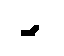

(5, 75, 75, 3)
1/1 [==============================] - 0s 148ms/step
---------------


ee
---------------


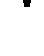

ee
---------------


juu
---------------


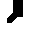

sho
---------------


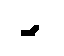

e
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 87ms/step
---------------


ee
---------------


la(2)
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Skeletonization
----------------------------------------------------


(2, 75, 75, 3)
1/1 [==============================] - 0s 94ms/step
---------------


ee
---------------


ka
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


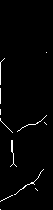

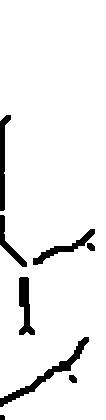

Skeletonization
----------------------------------------------------


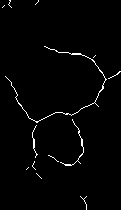

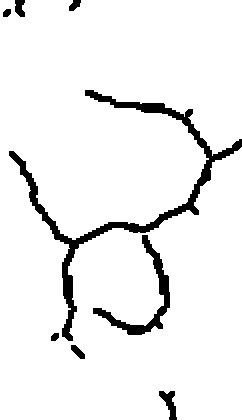

Skeletonization
----------------------------------------------------


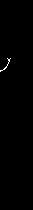

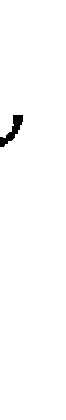

Skeletonization
----------------------------------------------------


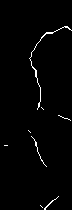

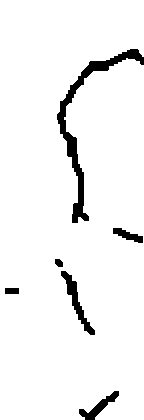

Skeletonization
----------------------------------------------------


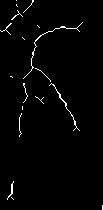

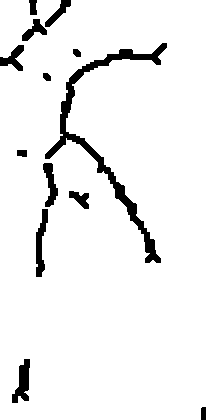

Skeletonization
----------------------------------------------------


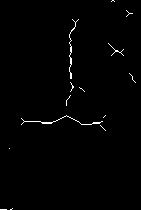

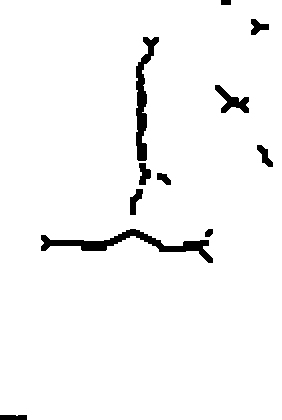

Skeletonization
----------------------------------------------------


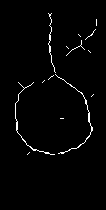

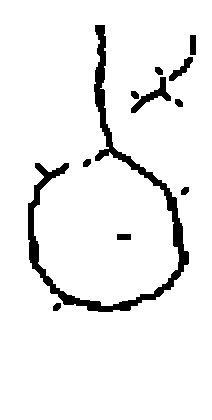

Skeletonization
----------------------------------------------------


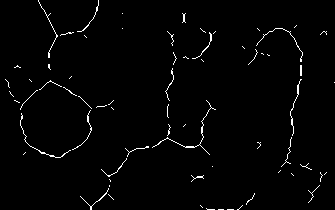

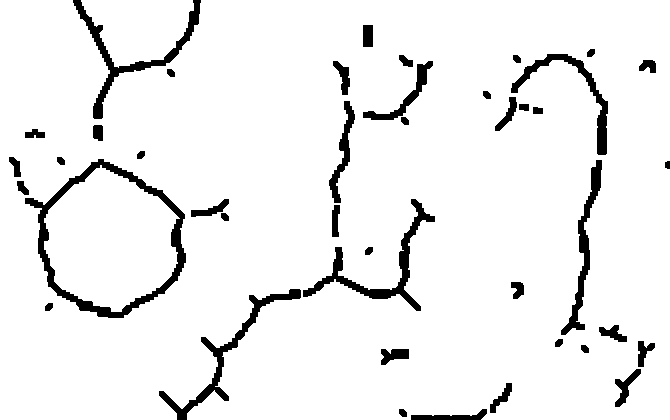

Skeletonization
----------------------------------------------------


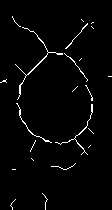

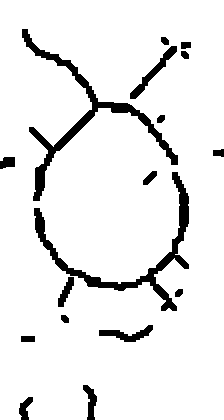

Skeletonization
----------------------------------------------------


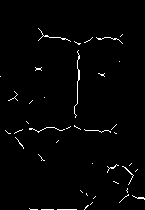

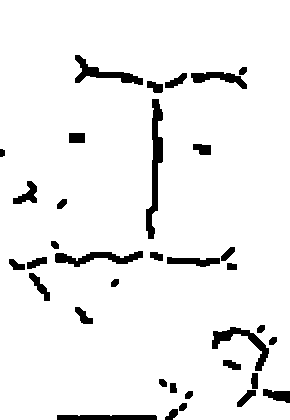

Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


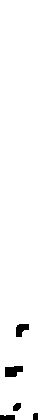

(12, 75, 75, 3)
1/1 [==============================] - 0s 231ms/step
---------------


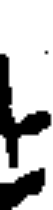

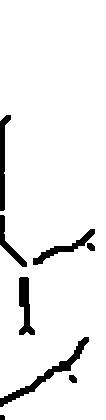

vhu
---------------


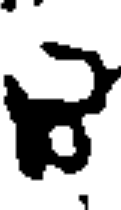

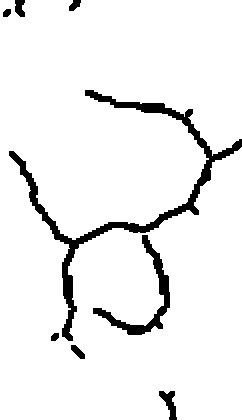

muu
---------------


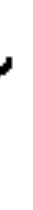

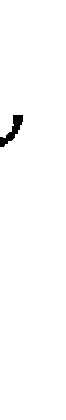

e
---------------


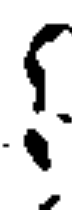

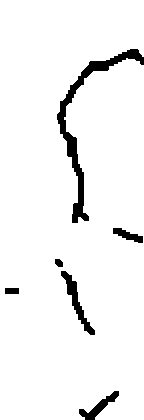

daaaa
---------------


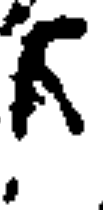

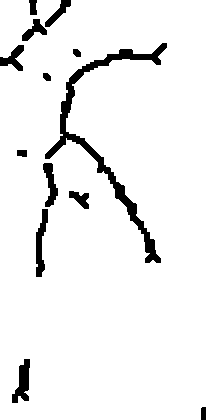

muu
---------------


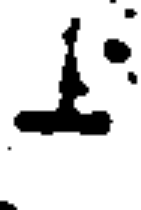

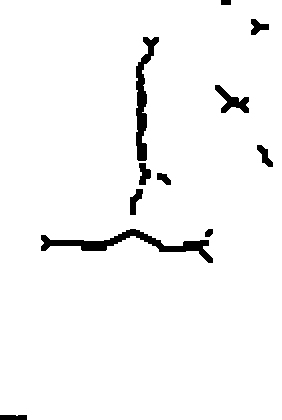

sho
---------------


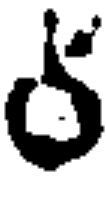

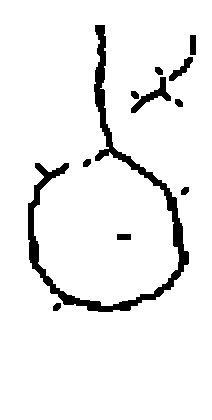

thaii
---------------


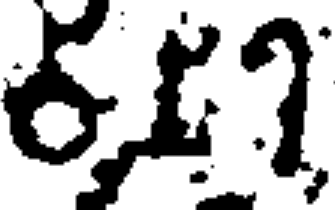

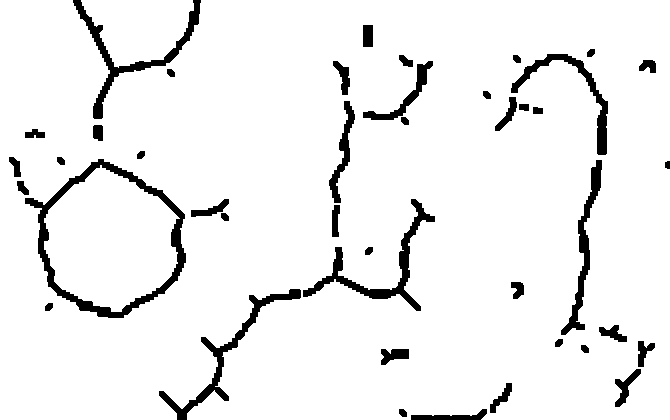

rii
---------------


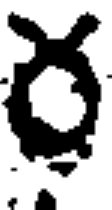

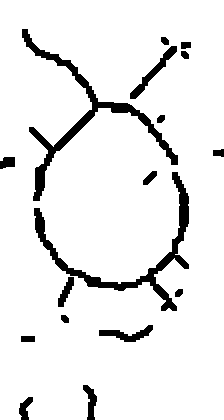

ro
---------------


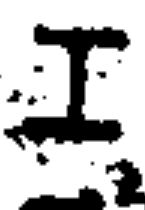

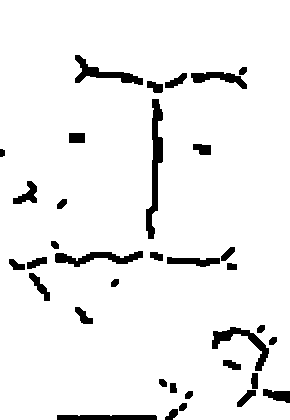

ghuu
---------------


ee
---------------


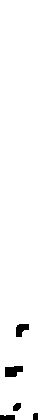

ro
char seg
----------------------------------------------------
Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


Skeletonization
----------------------------------------------------


(3, 75, 75, 3)
1/1 [==============================] - 0s 167ms/step
---------------


ee
---------------


la(2)
---------------


la(2)


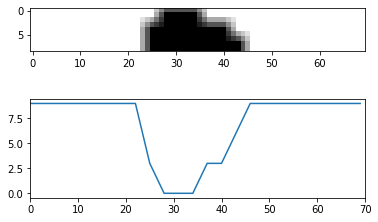

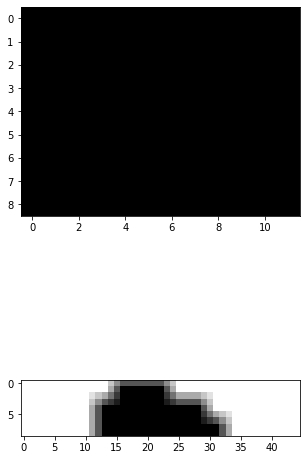

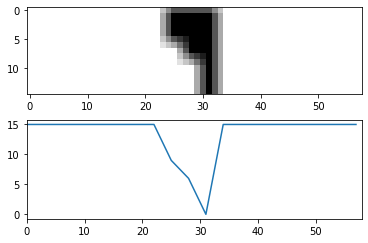

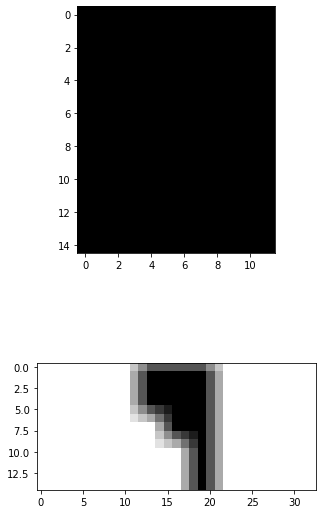

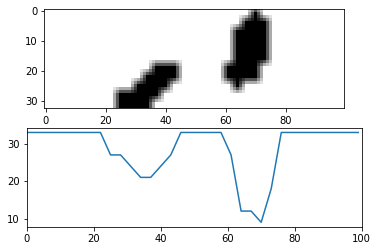

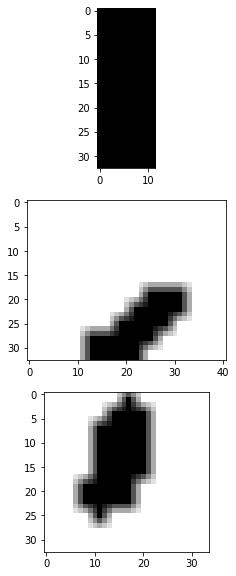

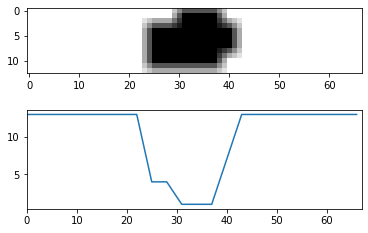

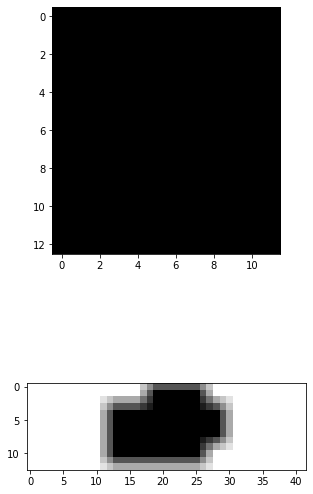

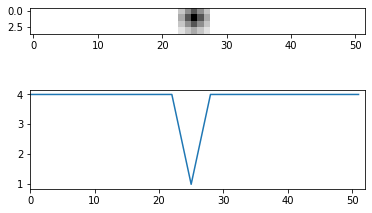

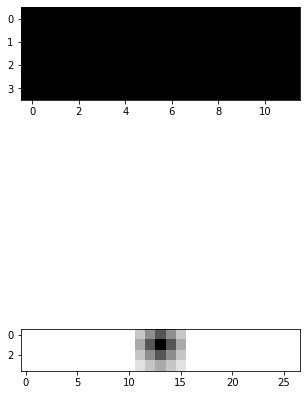

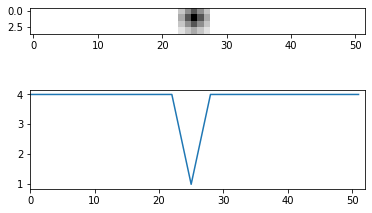

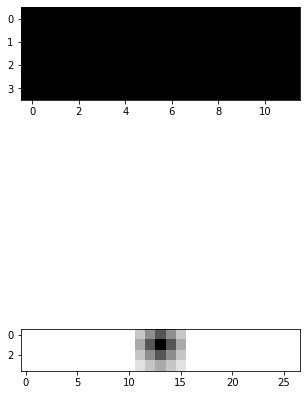

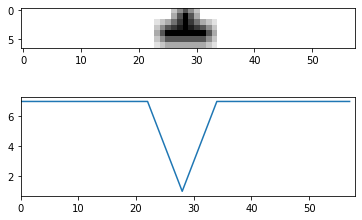

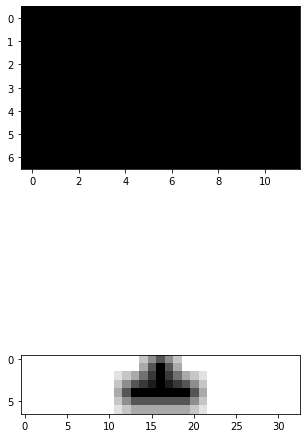

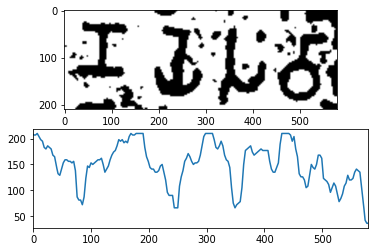

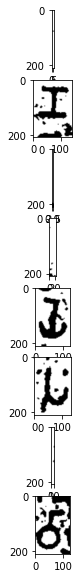

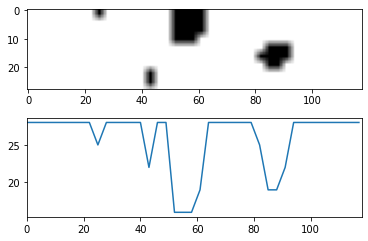

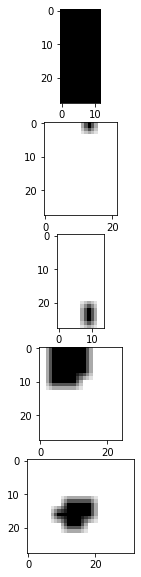

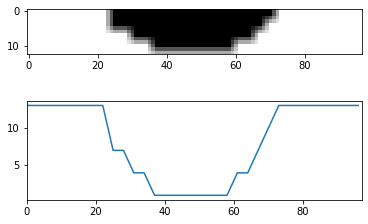

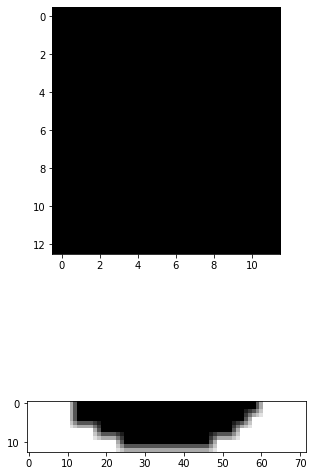

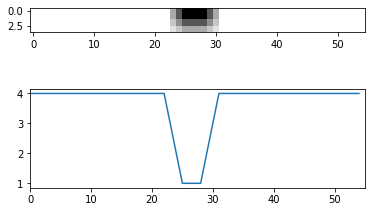

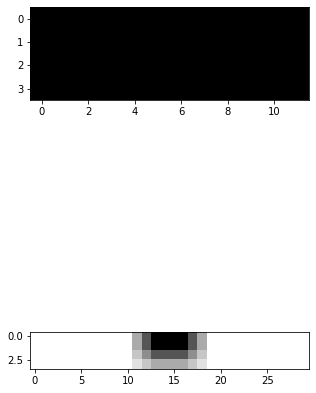

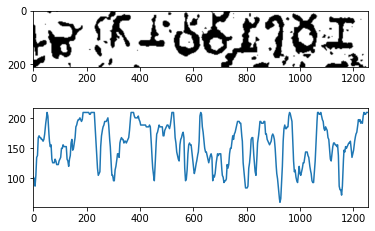

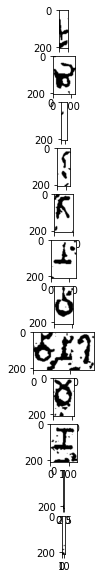

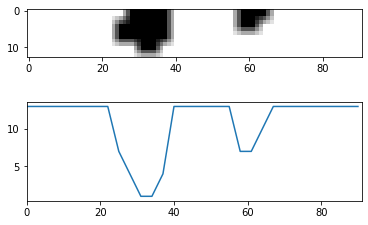

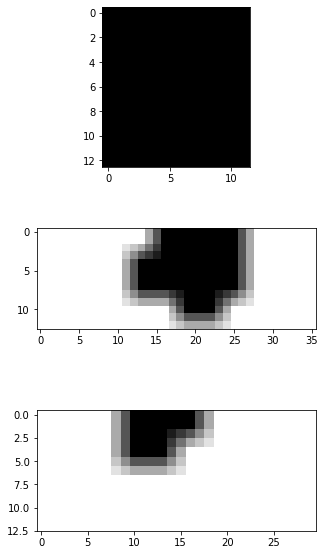

In [ ]:
char_seg_height = 15
blurring = 5
img = cv2.imread('/content/drive/MyDrive/Capstone Project/STONE IMAGES/b34.jpg')
cv2_imshow(img) 
#img = cv2.resize(img, (5*img.shape[1], 5*img.shape[0]))
cc_img = connectedcomp(img,blurring)
cc_img_resize = cv2.resize(cc_img, (3 * cc_img.shape[1], 3 * cc_img.shape[0]))
cv2_imshow(cc_img_resize)
cc_img_1 = check_invert(cc_img_resize)
cv2_imshow(cc_img_1) 
lines = lineseg(cc_img_1)
print(len(lines))
for i in lines:
  thinned_line = line_thinning(i)
  res_chars = charseg(thinned_line,char_seg_height)
  res_skel=[]
  for j in res_chars:
    temp_image = skeletonize1(j)
    res_skel.append(prune(temp_image))
  res_arr = predict_chars(res_skel)
  for k in range(len(res_skel)):
    print('---------------')
    cv2_imshow(res_chars[k])
    cv2_imshow(res_skel[k])
    print(res_arr[k])